In [1]:
import shap
shap.initjs()

# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load Dataset

In [5]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [6]:
df = df.drop('id', axis=1)

In [7]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [9]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

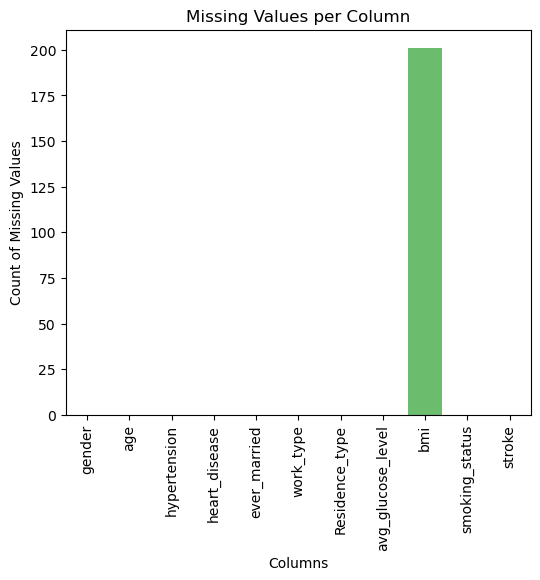

In [10]:
# Count missing values per column
missing_values = df.isnull().sum()

# Plot the missing values
plt.figure(figsize=(6, 5))
sns.barplot(
    x=missing_values.index,
    y=missing_values.values,
    hue=missing_values.index,
    legend=False,
    palette="viridis"
)

plt.xticks(rotation=90)
plt.title("Missing Values per Column")
plt.ylabel("Count of Missing Values")
plt.xlabel("Columns")
plt.show()

In [11]:
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

In [12]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [13]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [14]:
df.shape

(5110, 11)

In [15]:
print('Number of Features: %d'%(df.shape[1]))

Number of Features: 11


In [16]:
print('Number of Customers: %d'%(df.shape[0]))

Number of Customers: 5110


In [17]:
duplicate_rows = df[df.duplicated()]

# Number of duplicate rows
num_duplicates = len(duplicate_rows)

print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 0


# Visualize outliers

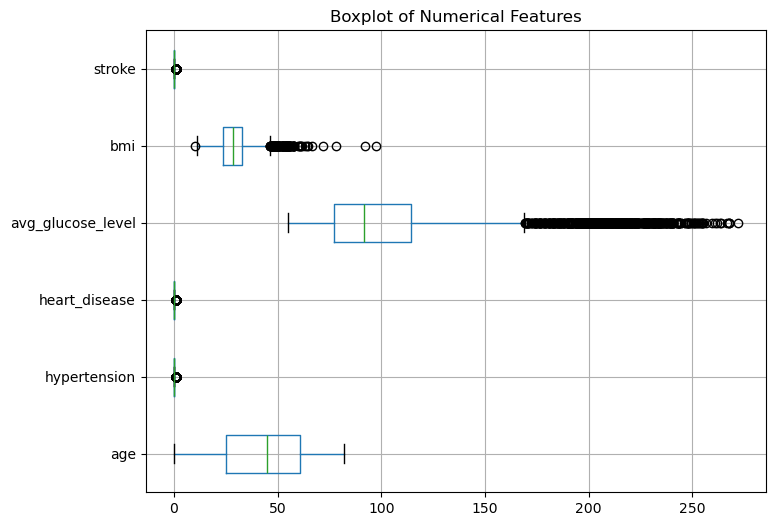

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot boxplots for numerical features
plt.figure(figsize=(8, 6))
num_columns = df.select_dtypes(include=['number']).columns.tolist()  # Convert to a list
df.boxplot(column=num_columns, vert=False)
plt.title("Boxplot of Numerical Features")
plt.show()


# Detect Outliers

In [21]:
import numpy as np

# Function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = np.percentile(data[column], 25)  # 25th percentile
    Q3 = np.percentile(data[column], 75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    return outliers

# Apply outlier detection to all numerical features
for col in df.select_dtypes(include=['number']).columns:
    outliers = detect_outliers_iqr(df, col)
    print(f"\n Outliers in {col}: {len(outliers)}")

    if not outliers.empty:
        print(outliers[[col]].head())  # Show some outliers


 Outliers in age: 0

 Outliers in hypertension: 498
    hypertension
4              1
6              1
10             1
15             1
17             1

 Outliers in heart_disease: 276
    heart_disease
0               1
2               1
6               1
11              1
13              1

 Outliers in avg_glucose_level: 627
   avg_glucose_level
0             228.69
1             202.21
3             171.23
4             174.12
5             186.21

 Outliers in bmi: 126
      bmi
21   48.9
66   47.5
113  56.6
254  50.1
258  54.6

 Outliers in stroke: 249
   stroke
0       1
1       1
2       1
3       1
4       1


# Graphs

<Axes: xlabel='gender', ylabel='count'>

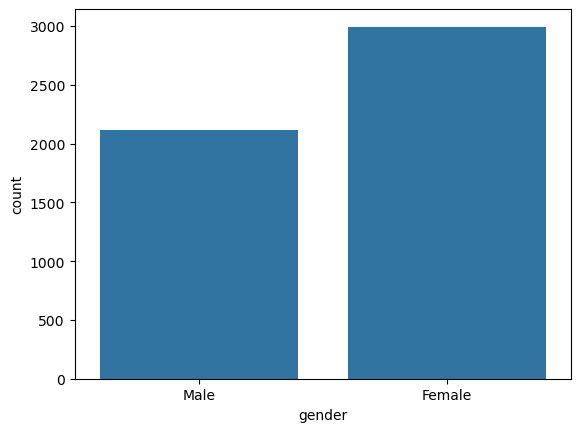

In [23]:
sns.countplot(x = df['gender'])

<Axes: xlabel='ever_married', ylabel='count'>

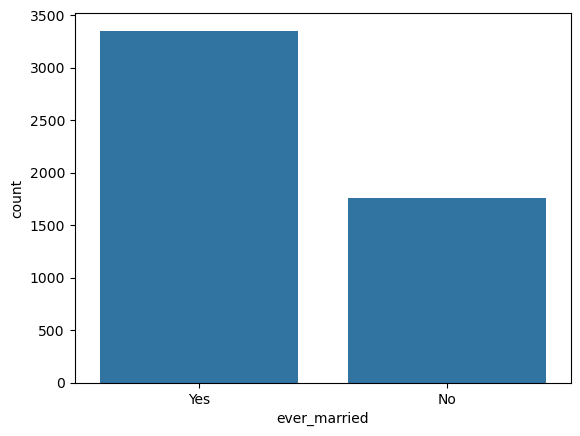

In [24]:
sns.countplot(x = df['ever_married'])

<Axes: xlabel='work_type', ylabel='count'>

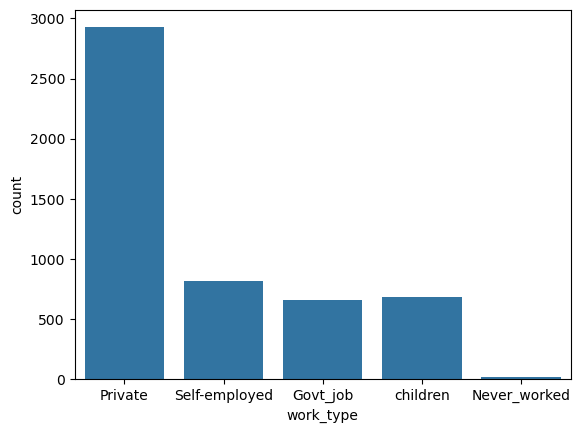

In [25]:
sns.countplot(x = df['work_type'])

<Axes: xlabel='Residence_type', ylabel='count'>

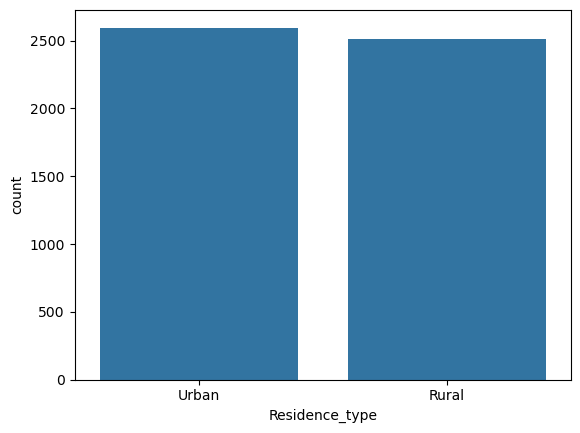

In [26]:
sns.countplot(x = df['Residence_type'])

<Axes: xlabel='smoking_status', ylabel='count'>

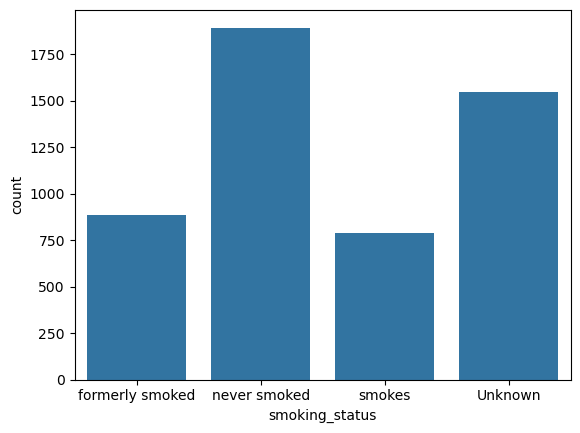

In [27]:
sns.countplot(x = df['smoking_status'])

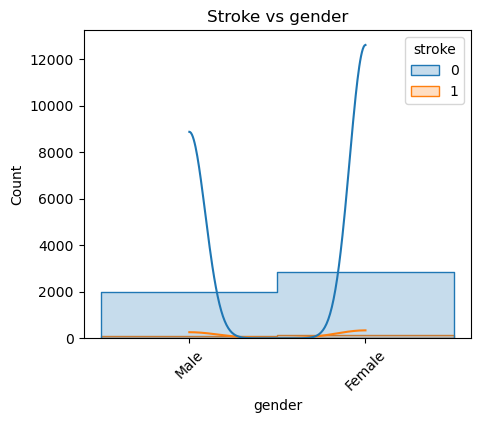

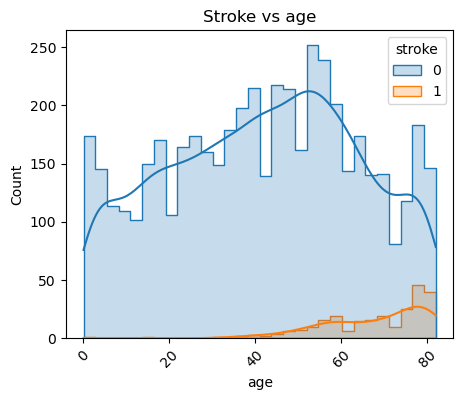

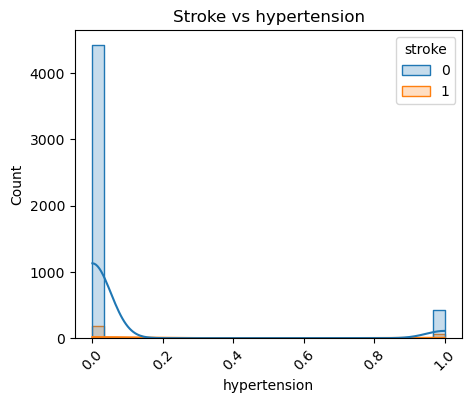

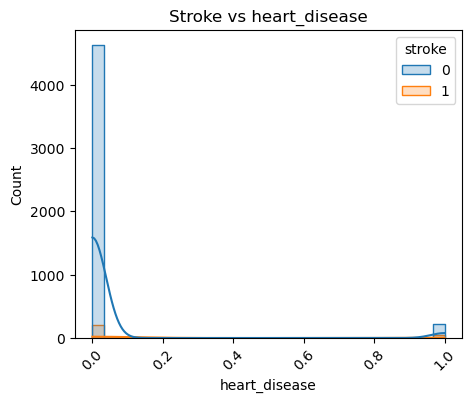

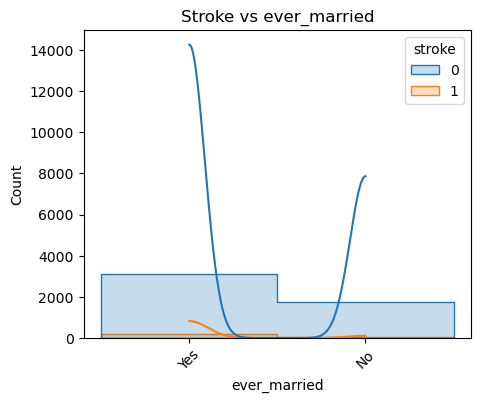

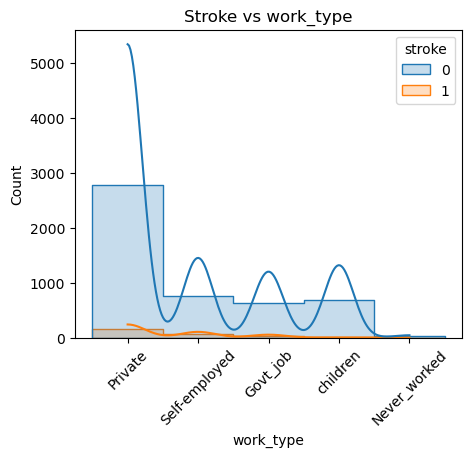

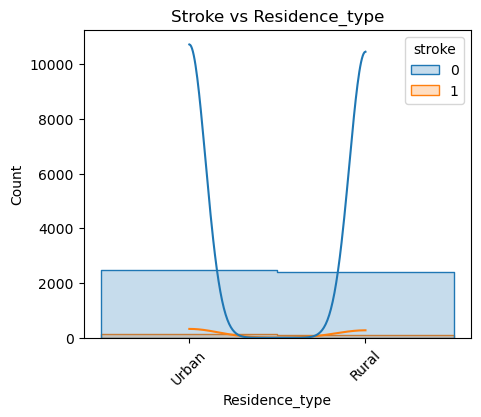

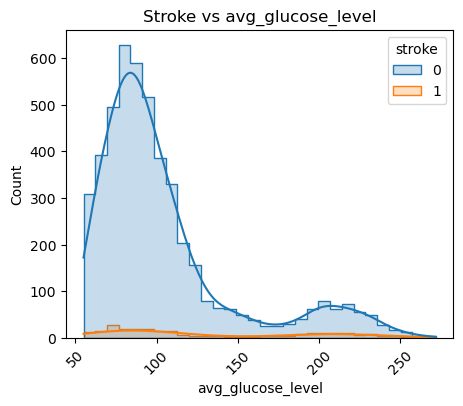

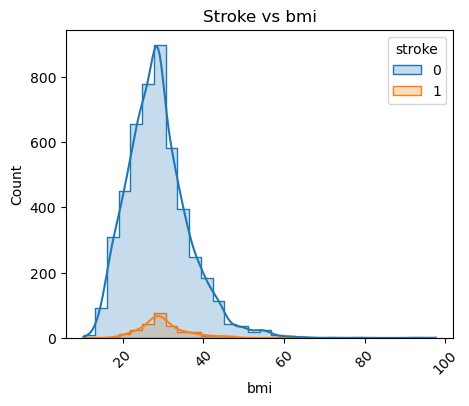

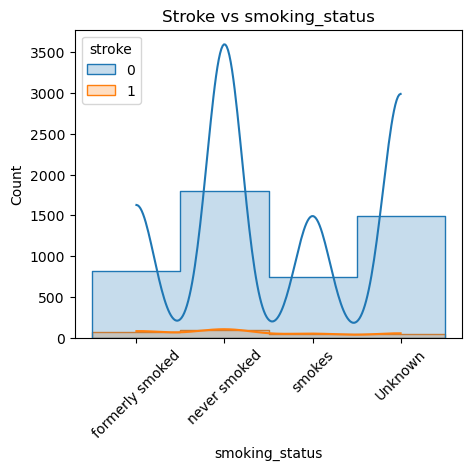

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (5, 4)

# Analyze target variable with all other columns
for col in df.columns:
    if col == "stroke":
        continue  # Skip the target column itself

    plt.figure()  # Create a new figure

    # Use histplot for both categorical and numerical features
    sns.histplot(data=df, x=col, hue="stroke", kde=True, bins=30, element="step", discrete=df[col].dtype == "object")

    plt.title(f"Stroke vs {col}")
    plt.xticks(rotation=45)  # Rotate labels if needed
    plt.show()

# correlation matrix

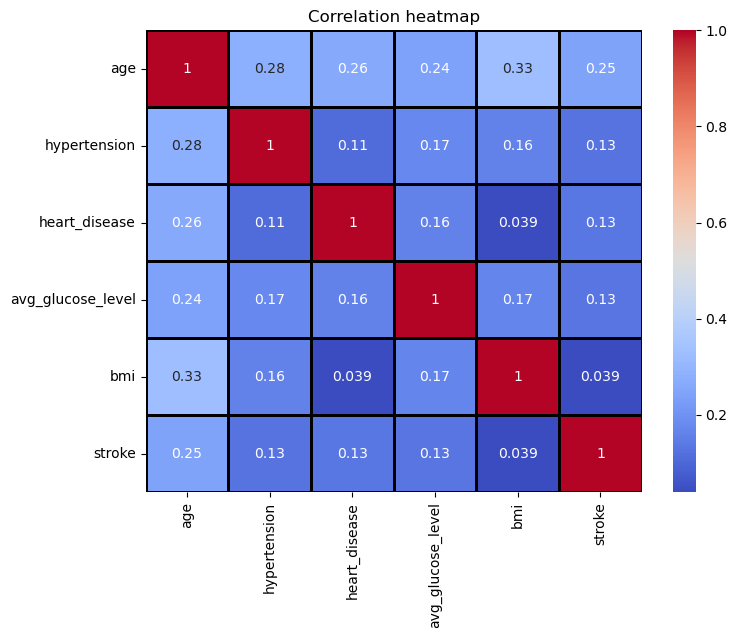

In [30]:
# Select only numeric columns
numeric_data = df.select_dtypes(include=['number'])

# Create a correlation matrix
correlation_matrix = numeric_data.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=2, linecolor='black')
plt.title('Correlation heatmap')
plt.show()

# Pair Plot

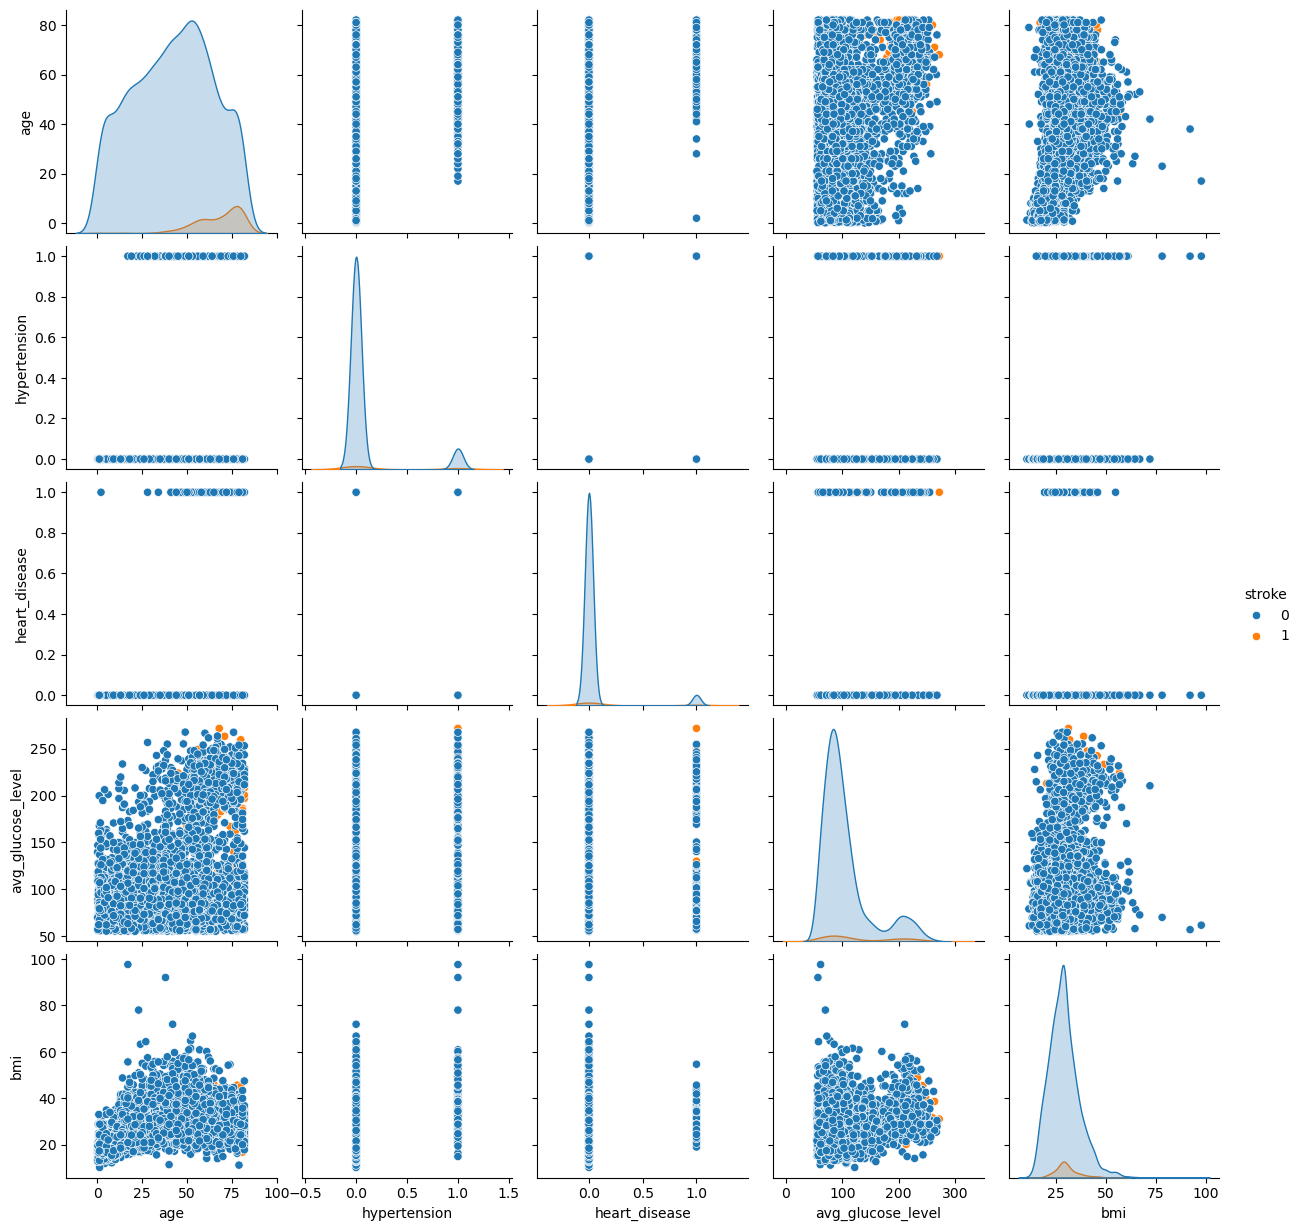

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pair plot
sns.pairplot(df, hue="stroke", diag_kind="kde")
plt.show()

# Label Encoding

In [34]:
from sklearn.preprocessing import LabelEncoder
categorical_columns = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status" ]

data2 = df.copy()
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data2[col] = le.fit_transform(data2[col])
    label_encoders[col] = le  # Save encoders if needed later

# Separate features (x) and target variable (y)
x = data2.drop(columns=['stroke'])  
y = data2['stroke']

data2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


# Scaling data

In [36]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
data2[['bmi', 'avg_glucose_level', 'age']] = s.fit_transform(data2[['bmi', 'avg_glucose_level', 'age']]) 
data3 = data2.copy()
data3.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,1.051434,0,1,1,2,1,2.706375,1.001234e+00,1,1
1,0,0.786070,0,0,1,3,0,2.121559,4.615554e-16,2,1
2,1,1.626390,0,1,1,2,0,-0.005028,4.685773e-01,2,1
3,0,0.255342,0,0,1,2,1,1.437358,7.154182e-01,3,1
4,0,1.582163,1,0,1,3,0,1.501184,-6.357112e-01,2,1


# Class Distribution

C:\Users\PMLS\AppData\Local\Temp\ipykernel_4628\352116310.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="stroke", data=df, palette="viridis")


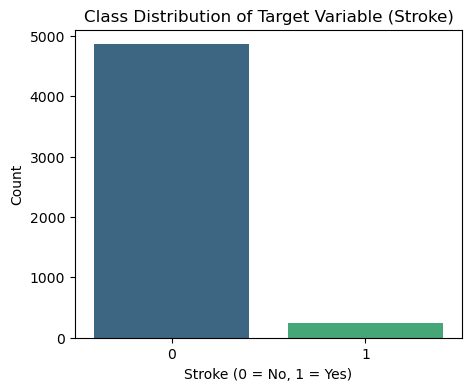

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.countplot(x="stroke", data=df, palette="viridis")
plt.title("Class Distribution of Target Variable (Stroke)")
plt.xlabel("Stroke (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [39]:
class_counts = df["stroke"].value_counts()
class_ratio = class_counts / len(df) * 100

print("✅ Class Distribution:")
print(class_counts)
print("\n✅ Class Imbalance Percentage:")
print(class_ratio)


✅ Class Distribution:
stroke
0    4861
1     249
Name: count, dtype: int64

✅ Class Imbalance Percentage:
stroke
0    95.127202
1     4.872798
Name: count, dtype: float64


# Remove Class Imbalance

In [41]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X=data3.drop(['stroke'],axis=1)
y=data3['stroke']
X_over, y_over = oversample.fit_resample(X, y)

print(y_over.value_counts())

stroke
1    4861
0    4861
Name: count, dtype: int64


C:\Users\PMLS\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\PMLS\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


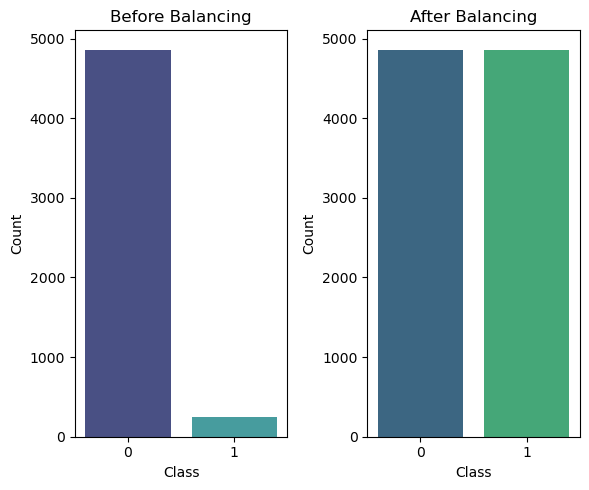

In [42]:
# Count original class distribution
original_counts = y.value_counts()

# Count new class distribution
balanced_counts = y_over.value_counts()

# Plotting the distributions side by side
fig, axes = plt.subplots(1, 2, figsize=(6, 5))

# Original data plot
sns.barplot(
    x=original_counts.index,
    y=original_counts.values,
    hue=original_counts.index,
    legend=False,
    ax=axes[0],
    palette="mako"
)
axes[0].set_title("Before Balancing")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Class")

# Balanced data plot
sns.barplot(
    x=balanced_counts.index,
    y=balanced_counts.values,
    hue=balanced_counts.index,
    legend=False,
    ax=axes[1],
    palette="viridis"
)
axes[1].set_title("After Balancing")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Class")

plt.tight_layout()
plt.show()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size= 0.2, random_state= 42)

# Apply models

# Logistic Regression


Classification Report - Logistic Regression:

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       975
           1       0.74      0.78      0.76       970

    accuracy                           0.76      1945
   macro avg       0.76      0.76      0.76      1945
weighted avg       0.76      0.76      0.76      1945

Train Accuracy: 0.7682
Test Accuracy: 0.7568


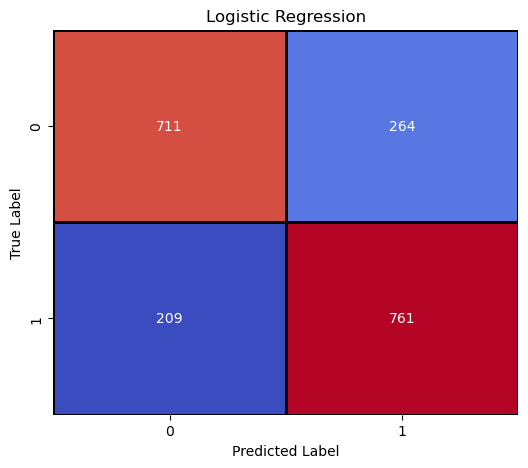

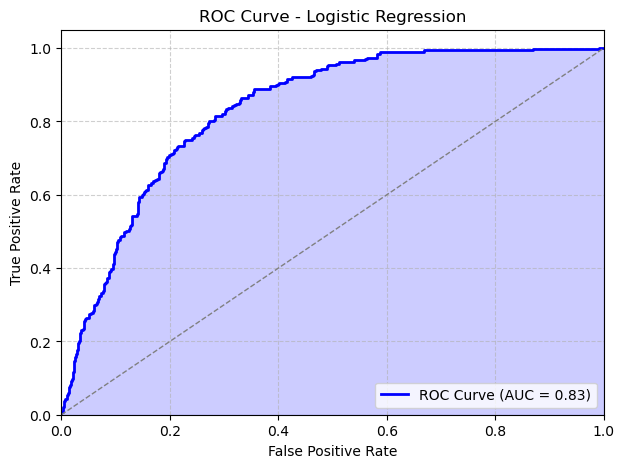

In [46]:
import warnings
from sklearn.exceptions import ConvergenceWarning  
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predictions
y_pred_logreg = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  

# Train & Test Accuracy
train_acc = accuracy_score(y_train, logreg.predict(X_train))
test_acc = accuracy_score(y_test, y_pred_logreg)

# Classification Report with Train & Test Accuracy
print("\nClassification Report - Logistic Regression:\n")
print(classification_report(y_test, y_pred_logreg))
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix with Prominent Grid Lines and Different Colors
cm = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', linewidths=2, linecolor='black', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic Regression")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Random model diagonal
plt.fill_between(fpr, tpr, alpha=0.2, color='blue')  # Shaded ROC area
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)  # Light grid lines
plt.show()

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Set up StratifiedKFold with 10 splits
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Track scores for each fold
fold_accuracies = []

# Go through each fold manually
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    # Split data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model on the current fold
    logreg.fit(X_fold_train, y_fold_train)

    # Make predictions and evaluate
    y_pred = logreg.predict(X_fold_val)
    accuracy = accuracy_score(y_fold_val, y_pred)
    fold_accuracies.append(accuracy)

    # Print results for this fold
    print(f"Fold {fold}: Cross Validation Accuracy = {accuracy:.4f}")

# Final average accuracy
print(f"Average Cross Validation Accuracy across 10 folds: {sum(fold_accuracies) / len(fold_accuracies):.4f}")

Fold 1: Cross Validation Accuracy = 0.7609
Fold 2: Cross Validation Accuracy = 0.7416
Fold 3: Cross Validation Accuracy = 0.7789
Fold 4: Cross Validation Accuracy = 0.7674
Fold 5: Cross Validation Accuracy = 0.7789
Fold 6: Cross Validation Accuracy = 0.7725
Fold 7: Cross Validation Accuracy = 0.7712
Fold 8: Cross Validation Accuracy = 0.7580
Fold 9: Cross Validation Accuracy = 0.7683
Fold 10: Cross Validation Accuracy = 0.7722
Average Cross Validation Accuracy across 10 folds: 0.7670


# Random Forest


Classification Report - Random Forest:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       975
           1       0.99      1.00      1.00       970

    accuracy                           1.00      1945
   macro avg       1.00      1.00      1.00      1945
weighted avg       1.00      1.00      1.00      1945

Accuracy: 0.9969
 Train Accuracy: 1.0000
 Test Accuracy: 0.9969


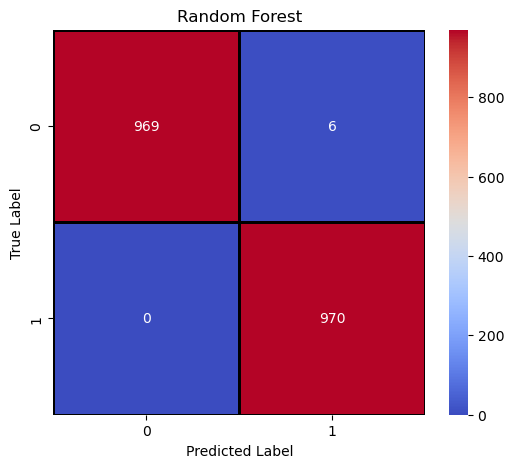

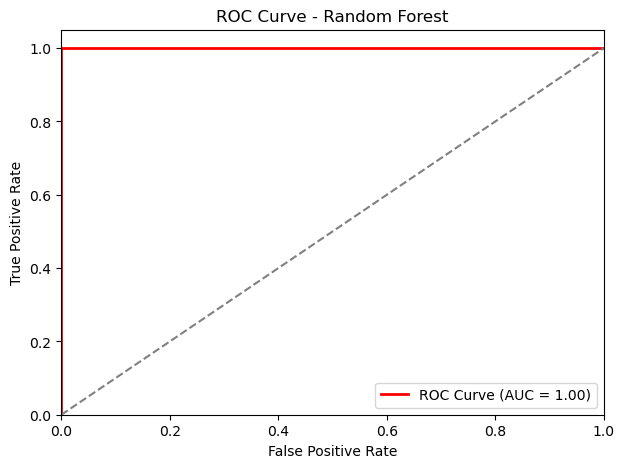

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]  # Probabilities for ROC Curve

# Classification Report
print("\nClassification Report - Random Forest:\n")
print(classification_report(y_test, y_pred_rf))
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}')

# Train & Test Accuracy
train_acc_rf = rf.score(X_train, y_train)
test_acc_rf = rf.score(X_test, y_test)
print(f" Train Accuracy: {train_acc_rf:.4f}")
print(f" Test Accuracy: {test_acc_rf:.4f}")

# Confusion Matrix Visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='coolwarm', linewidths=2, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest")
plt.show()

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)  # Fixed variable name
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7, 5))
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Set up StratifiedKFold with 10 splits
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Track accuracy for each fold
fold_accuracies = []

# Go through each fold manually
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    # Split data for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train Random Forest on the current fold
    rf.fit(X_fold_train, y_fold_train)

    # Make predictions and evaluate
    y_pred_fold = rf.predict(X_fold_val)
    accuracy = accuracy_score(y_fold_val, y_pred_fold)
    fold_accuracies.append(accuracy)

    # Print results for this fold
    print(f" Fold {fold}: Cross Validation Accuracy = {accuracy:.4f}")

# Final average accuracy
print(f" Average Cross Validation Accuracy across 10 folds: {sum(fold_accuracies) / len(fold_accuracies):.4f}")

 Fold 1: Cross Validation Accuracy = 0.9923
 Fold 2: Cross Validation Accuracy = 0.9910
 Fold 3: Cross Validation Accuracy = 0.9987
 Fold 4: Cross Validation Accuracy = 0.9884
 Fold 5: Cross Validation Accuracy = 0.9923
 Fold 6: Cross Validation Accuracy = 0.9961
 Fold 7: Cross Validation Accuracy = 0.9859
 Fold 8: Cross Validation Accuracy = 0.9871
 Fold 9: Cross Validation Accuracy = 0.9858
 Fold 10: Cross Validation Accuracy = 0.9923
 Average Cross Validation Accuracy across 10 folds: 0.9910



 Classification Report
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       975
           1       0.74      0.88      0.81       970

    accuracy                           0.79      1945
   macro avg       0.80      0.79      0.79      1945
weighted avg       0.80      0.79      0.79      1945

Accuracy: 0.7887
 Train Accuracy: 0.8024
 Test Accuracy: 0.7887


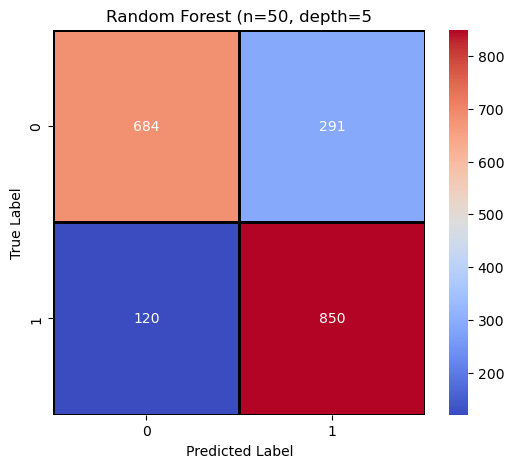

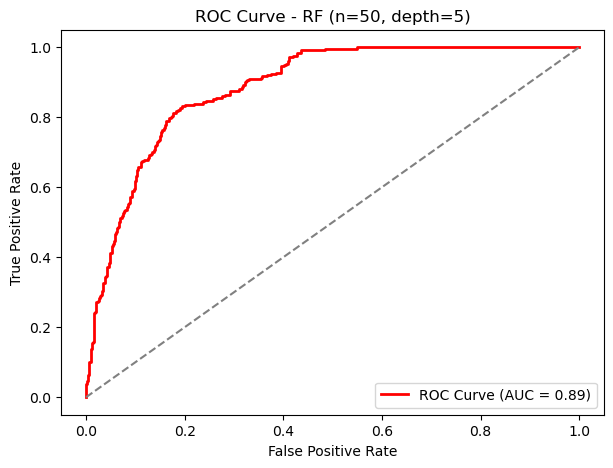

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train the first Random Forest model
rf1 = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
rf1.fit(X_train, y_train)

# Predictions
y_pred_rf1 = rf1.predict(X_test)
y_pred_prob_rf1 = rf1.predict_proba(X_test)[:, 1]

# Classification Report
print("\n Classification Report")
print(classification_report(y_test, y_pred_rf1))
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf1):.4f}')

# Train & Test Accuracy
train_acc_rf1 = rf1.score(X_train, y_train)
test_acc_rf1 = rf1.score(X_test, y_test)
print(f" Train Accuracy: {train_acc_rf1:.4f}")
print(f" Test Accuracy: {test_acc_rf1:.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf1), annot=True, fmt='d', cmap='coolwarm', linewidths=2, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest (n=50, depth=5")
plt.show()

# ROC Curve
fpr_rf1, tpr_rf1, _ = roc_curve(y_test, y_pred_prob_rf1)
roc_auc_rf1 = auc(fpr_rf1, tpr_rf1)

plt.figure(figsize=(7, 5))
plt.plot(fpr_rf1, tpr_rf1, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc_rf1:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RF (n=50, depth=5)')
plt.legend(loc="lower right")
plt.show()



Classification Report
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       975
           1       0.89      0.99      0.94       970

    accuracy                           0.94      1945
   macro avg       0.94      0.94      0.94      1945
weighted avg       0.94      0.94      0.94      1945

Accuracy: 0.9362
 Train Accuracy: 0.9527
 Test Accuracy: 0.9362


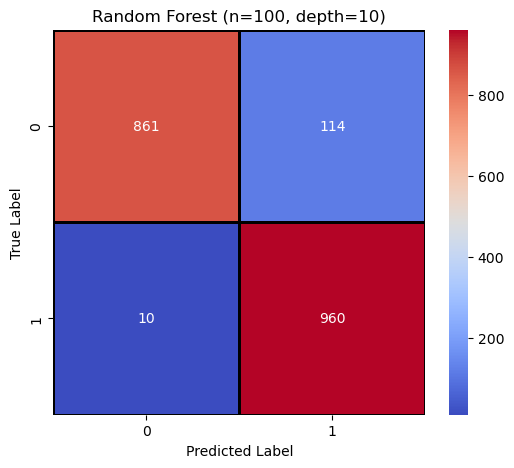

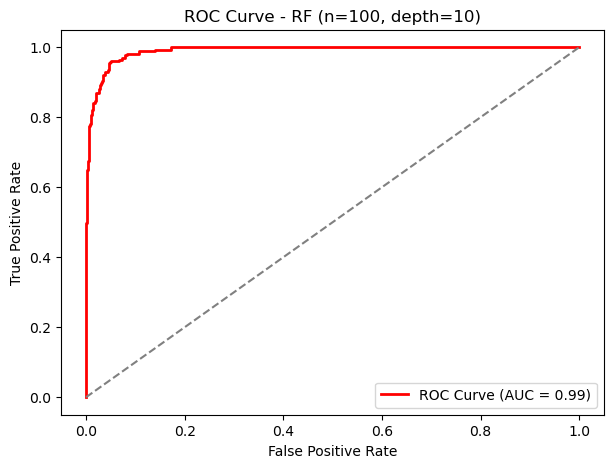

In [52]:
# Train the second Random Forest model
rf2 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf2.fit(X_train, y_train)

# Predictions
y_pred_rf2 = rf2.predict(X_test)
y_pred_prob_rf2 = rf2.predict_proba(X_test)[:, 1]

# Classification Report
print("\nClassification Report")
print(classification_report(y_test, y_pred_rf2))
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf2):.4f}')

# Train & Test Accuracy
train_acc_rf2 = rf2.score(X_train, y_train)
test_acc_rf2 = rf2.score(X_test, y_test)
print(f" Train Accuracy: {train_acc_rf2:.4f}")
print(f" Test Accuracy: {test_acc_rf2:.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf2), annot=True, fmt='d', cmap='coolwarm', linewidths=2, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest (n=100, depth=10)")
plt.show()

# ROC Curve
fpr_rf2, tpr_rf2, _ = roc_curve(y_test, y_pred_prob_rf2)
roc_auc_rf2 = auc(fpr_rf2, tpr_rf2)

plt.figure(figsize=(7, 5))
plt.plot(fpr_rf2, tpr_rf2, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc_rf2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RF (n=100, depth=10)')
plt.legend(loc="lower right")
plt.show()


<>:10: SyntaxWarning: invalid escape sequence '\C'
<>:10: SyntaxWarning: invalid escape sequence '\C'
C:\Users\PMLS\AppData\Local\Temp\ipykernel_4628\1444077385.py:10: SyntaxWarning: invalid escape sequence '\C'
  print("\Classification Report")


\Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       975
           1       0.99      1.00      0.99       970

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945

Accuracy: 0.9949
 Train Accuracy: 1.0000
 Test Accuracy: 0.9949


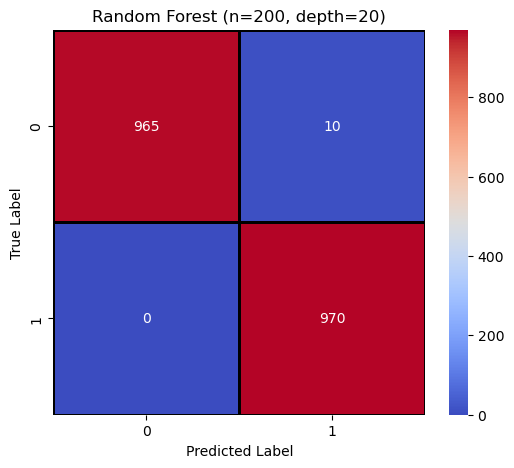

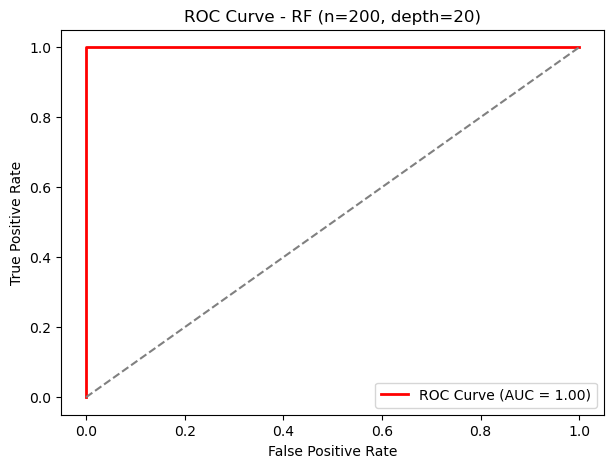

In [53]:
# Train the third Random Forest model
rf3 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf3.fit(X_train, y_train)

# Predictions
y_pred_rf3 = rf3.predict(X_test)
y_pred_prob_rf3 = rf3.predict_proba(X_test)[:, 1]

# Classification Report
print("\Classification Report")
print(classification_report(y_test, y_pred_rf3))
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf3):.4f}')

# Train & Test Accuracy
train_acc_rf3 = rf3.score(X_train, y_train)
test_acc_rf3 = rf3.score(X_test, y_test)
print(f" Train Accuracy: {train_acc_rf3:.4f}")
print(f" Test Accuracy: {test_acc_rf3:.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf3), annot=True, fmt='d', cmap='coolwarm', linewidths=2, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest (n=200, depth=20)")
plt.show()

# ROC Curve
fpr_rf3, tpr_rf3, _ = roc_curve(y_test, y_pred_prob_rf3)
roc_auc_rf3 = auc(fpr_rf3, tpr_rf3)

plt.figure(figsize=(7, 5))
plt.plot(fpr_rf3, tpr_rf3, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc_rf3:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RF (n=200, depth=20)')
plt.legend(loc="lower right")
plt.show()


# Support Vector Machine (SVM)


Classification Report - Support Vector Machine:

              precision    recall  f1-score   support

           0       0.84      0.72      0.78       975
           1       0.75      0.86      0.81       970

    accuracy                           0.79      1945
   macro avg       0.80      0.79      0.79      1945
weighted avg       0.80      0.79      0.79      1945

 Train Accuracy: 0.8110
 Test Accuracy: 0.7923


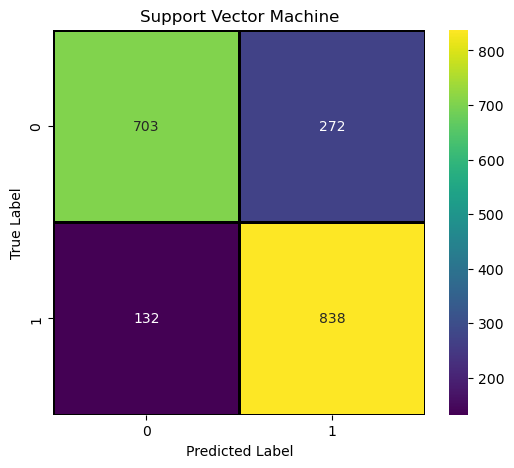

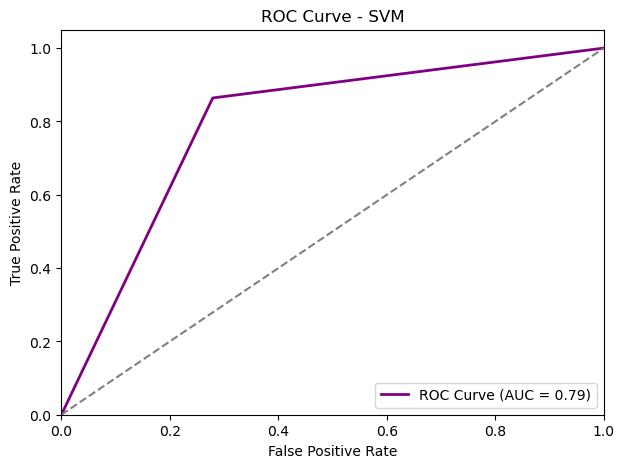

In [55]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Train SVM
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Classification Report
print("\nClassification Report - Support Vector Machine:\n")
print(classification_report(y_test, y_pred_svm))

# Train & Test Accuracy
train_acc_svm = svm.score(X_train, y_train)
test_acc_svm = svm.score(X_test, y_test)
print(f" Train Accuracy: {train_acc_svm:.4f}")
print(f" Test Accuracy: {test_acc_svm:.4f}")

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='viridis', linewidths=2, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Support Vector Machine")
plt.show()

# ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(7, 5))
plt.plot(fpr_svm, tpr_svm, color='purple', lw=2, label=f'ROC Curve (AUC = {roc_auc_svm:.2f})')  
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()

In [56]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Set up StratifiedKFold with 10 splits
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Track accuracies for each fold
fold_accuracies = []

# Go through each fold manually
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    # Split data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the SVM model on the current fold
    svm.fit(X_fold_train, y_fold_train)

    # Make predictions and evaluate
    y_pred = svm.predict(X_fold_val)
    accuracy = accuracy_score(y_fold_val, y_pred)
    fold_accuracies.append(accuracy)

    # Print results for this fold
    print(f" Fold {fold}: Cross Validation Accuracy = {accuracy:.4f}")

# Final average accuracy
print(f"\n Average Cross Validation Accuracy across 10 folds: {sum(fold_accuracies) / len(fold_accuracies):.4f}")

 Fold 1: Cross Validation Accuracy = 0.7956
 Fold 2: Cross Validation Accuracy = 0.7866
 Fold 3: Cross Validation Accuracy = 0.8008
 Fold 4: Cross Validation Accuracy = 0.7969
 Fold 5: Cross Validation Accuracy = 0.8201
 Fold 6: Cross Validation Accuracy = 0.8188
 Fold 7: Cross Validation Accuracy = 0.8111
 Fold 8: Cross Validation Accuracy = 0.8069
 Fold 9: Cross Validation Accuracy = 0.7889
 Fold 10: Cross Validation Accuracy = 0.8095

 Average Cross Validation Accuracy across 10 folds: 0.8035


# Decision Tree


Classification Report - Decision Tree:

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       975
           1       0.83      0.90      0.87       970

    accuracy                           0.86      1945
   macro avg       0.86      0.86      0.86      1945
weighted avg       0.86      0.86      0.86      1945

Train Accuracy: 0.8804
Test Accuracy: 0.8612


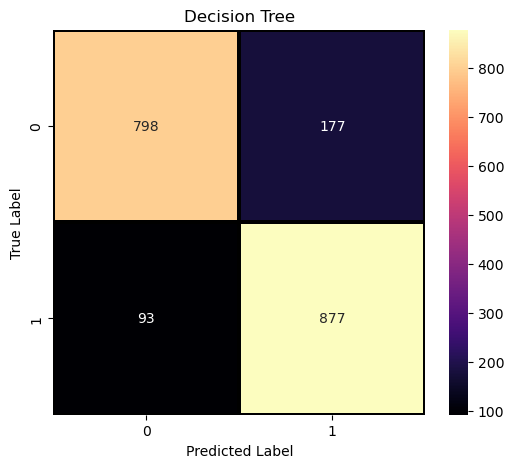

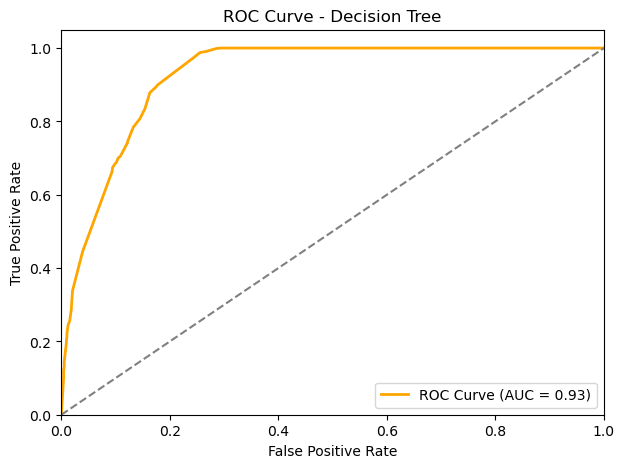

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Train Decision Tree Classifier with modified hyperparameters
dt = DecisionTreeClassifier(
    criterion="entropy",  # Using entropy instead of Gini
    max_depth=8,  # Limit tree depth to prevent overfitting
    min_samples_split=10,  # Require at least 10 samples to split a node
    min_samples_leaf=5,  # Each leaf must have at least 5 samples
    class_weight="balanced",  # Handle class imbalance
    random_state=42)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# Classification Report
print("\nClassification Report - Decision Tree:\n")
print(classification_report(y_test, y_pred_dt))
# Train & Test Accuracy
train_acc_dt = dt.score(X_train, y_train)
test_acc_dt = dt.score(X_test, y_test)
print(f"Train Accuracy: {train_acc_dt:.4f}")
print(f"Test Accuracy: {test_acc_dt:.4f}")

# Confusion Matrix with different colors
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='magma', linewidths=1.5, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Decision Tree")
plt.show()

# ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(7, 5))
plt.plot(fpr_dt, tpr_dt, color='orange', lw=2, label=f'ROC Curve (AUC = {roc_auc_dt:.2f})')  # Different color
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

In [59]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Set up StratifiedKFold with 10 splits
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Track accuracies for each fold
fold_accuracies = []

# Go through each fold manually
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    # Split data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the Decision Tree model on the current fold
    dt.fit(X_fold_train, y_fold_train)

    # Make predictions and evaluate
    y_pred = dt.predict(X_fold_val)
    accuracy = accuracy_score(y_fold_val, y_pred)
    fold_accuracies.append(accuracy)

    # Print results for this fold
    print(f" Fold {fold}: Cross Validation Accuracy = {accuracy:.4f}")

# Final average accuracy across all folds
print(f"\n Average Cross Validation Accuracy across 10 folds: {sum(fold_accuracies) / len(fold_accuracies):.4f}")


 Fold 1: Cross Validation Accuracy = 0.8676
 Fold 2: Cross Validation Accuracy = 0.8355
 Fold 3: Cross Validation Accuracy = 0.8753
 Fold 4: Cross Validation Accuracy = 0.8715
 Fold 5: Cross Validation Accuracy = 0.8496
 Fold 6: Cross Validation Accuracy = 0.8638
 Fold 7: Cross Validation Accuracy = 0.8599
 Fold 8: Cross Validation Accuracy = 0.8533
 Fold 9: Cross Validation Accuracy = 0.8481
 Fold 10: Cross Validation Accuracy = 0.8803

 Average Cross Validation Accuracy across 10 folds: 0.8605


# K-Nearest Neighbors (KNN)


Classification Report - K-Nearest Neighbors:

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       975
           1       0.78      1.00      0.87       970

    accuracy                           0.86      1945
   macro avg       0.89      0.86      0.85      1945
weighted avg       0.89      0.86      0.85      1945

Train Accuracy: 0.8678
Test Accuracy: 0.8560


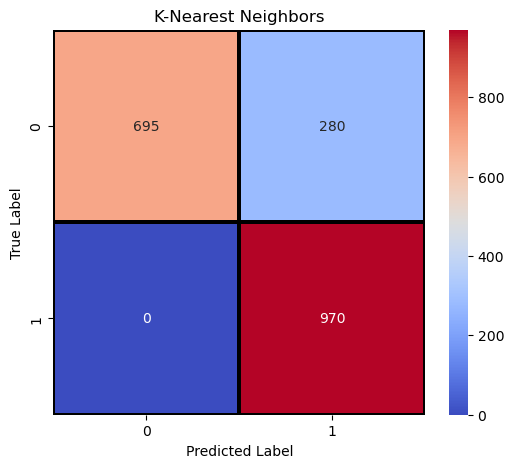

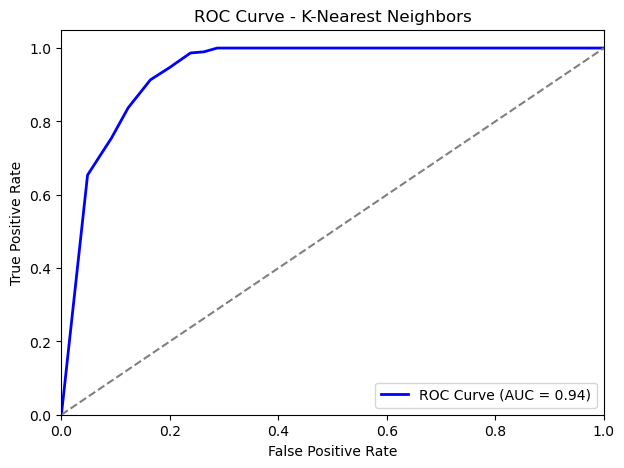

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Scale features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN Classifier with different hyperparameters
knn = KNeighborsClassifier(
    n_neighbors=15,  # Increased neighbors
    weights='uniform',  # Try uniform weights for less sensitivity to outliers
    metric='euclidean'  # Switch to Euclidean distance (or keep Manhattan if it works better)
)


knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
y_pred_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]  # Get probability for the positive class

# Classification Report
print("\nClassification Report - K-Nearest Neighbors:\n")
print(classification_report(y_test, y_pred_knn))
# Train & Test Accuracy
train_acc_knn = knn.score(X_train_scaled, y_train)
test_acc_knn = knn.score(X_test_scaled, y_test)
print(f"Train Accuracy: {train_acc_knn:.4f}")
print(f"Test Accuracy: {test_acc_knn:.4f}")

# Confusion Matrix with different colormap
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='coolwarm', linewidths=1.5, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("K-Nearest Neighbors")
plt.show()

# ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(7, 5))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - K-Nearest Neighbors')
plt.legend(loc="lower right")
plt.show()

In [62]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Set up StratifiedKFold with 10 splits
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Track accuracies for each fold
fold_accuracies = []

# Go through each fold manually
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train), 1):
    # Split data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the KNN model on the current fold
    knn.fit(X_fold_train, y_fold_train)

    # Make predictions and evaluate
    y_pred = knn.predict(X_fold_val)
    accuracy = accuracy_score(y_fold_val, y_pred)
    fold_accuracies.append(accuracy)

    # Print results for this fold
    print(f" Fold {fold}: Cross Validation Accuracy = {accuracy:.4f}")

# Final average accuracy across all folds
print(f"\n Average Cross Validation Accuracy across 10 folds: {sum(fold_accuracies) / len(fold_accuracies):.4f}")


 Fold 1: Cross Validation Accuracy = 0.8445
 Fold 2: Cross Validation Accuracy = 0.8316
 Fold 3: Cross Validation Accuracy = 0.8470
 Fold 4: Cross Validation Accuracy = 0.8355
 Fold 5: Cross Validation Accuracy = 0.8573
 Fold 6: Cross Validation Accuracy = 0.8496
 Fold 7: Cross Validation Accuracy = 0.8496
 Fold 8: Cross Validation Accuracy = 0.8571
 Fold 9: Cross Validation Accuracy = 0.8417
 Fold 10: Cross Validation Accuracy = 0.8353

 Average Cross Validation Accuracy across 10 folds: 0.8449


# XGBoost


Classification Report - XGBoost:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       975
           1       0.96      1.00      0.98       970

    accuracy                           0.98      1945
   macro avg       0.98      0.98      0.98      1945
weighted avg       0.98      0.98      0.98      1945

 Train Accuracy: 0.9960
 Test Accuracy: 0.9779


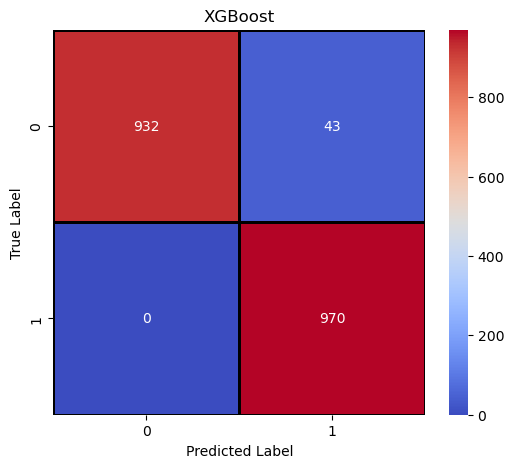

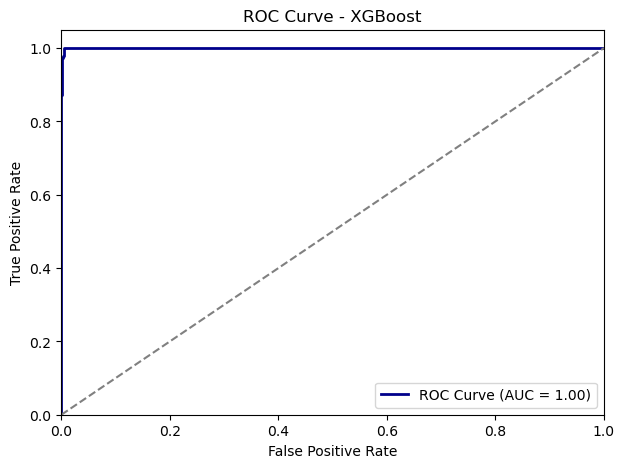

In [64]:
import warnings
from sklearn.exceptions import ConvergenceWarning  # Import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)  # Suppress only ConvergenceWarnings
warnings.simplefilter(action='ignore', category=UserWarning)

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Train XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# Classification Report
print("\nClassification Report - XGBoost:\n")
print(classification_report(y_test, y_pred_xgb))

# Train & Test Accuracy
train_acc_xgb = xgb.score(X_train, y_train)
test_acc_xgb = xgb.score(X_test, y_test)
print(f" Train Accuracy: {train_acc_xgb:.4f}")
print(f" Test Accuracy: {test_acc_xgb:.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='coolwarm', linewidths=2, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost")
plt.show()

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(7, 5))
plt.plot(fpr_xgb, tpr_xgb, color='darkblue', lw=2, label=f'ROC Curve (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

In [65]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Set up StratifiedKFold with 10 splits
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Track accuracies for each fold
fold_accuracies = []

# Go through each fold manually
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    # Split data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the XGBoost model on the current fold
    xgb.fit(X_fold_train, y_fold_train)

    # Make predictions and evaluate
    y_pred = xgb.predict(X_fold_val)
    accuracy = accuracy_score(y_fold_val, y_pred)
    fold_accuracies.append(accuracy)

    # Print results for this fold
    print(f" Fold {fold}: Accuracy = {accuracy:.4f}")

# Final average accuracy across all folds
print(f"\n Average Accuracy across 10 folds: {sum(fold_accuracies) / len(fold_accuracies):.4f}")


 Fold 1: Accuracy = 0.9692
 Fold 2: Accuracy = 0.9756
 Fold 3: Accuracy = 0.9756
 Fold 4: Accuracy = 0.9627
 Fold 5: Accuracy = 0.9781
 Fold 6: Accuracy = 0.9743
 Fold 7: Accuracy = 0.9666
 Fold 8: Accuracy = 0.9691
 Fold 9: Accuracy = 0.9627
 Fold 10: Accuracy = 0.9768

 Average Accuracy across 10 folds: 0.9711


# CatBoost


Classification Report - CatBoost:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       975
           1       0.97      1.00      0.98       970

    accuracy                           0.98      1945
   macro avg       0.98      0.98      0.98      1945
weighted avg       0.98      0.98      0.98      1945

Train Accuracy: 0.9990
Test Accuracy: 0.9820


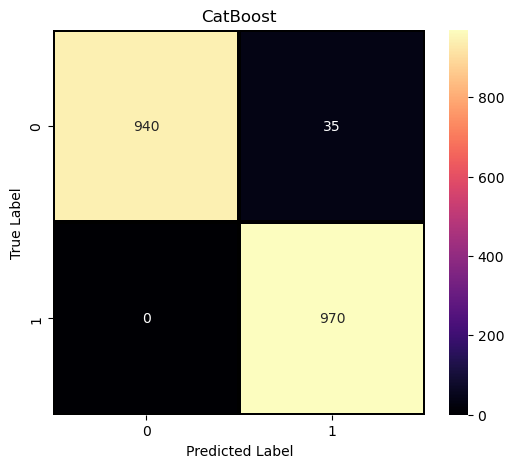

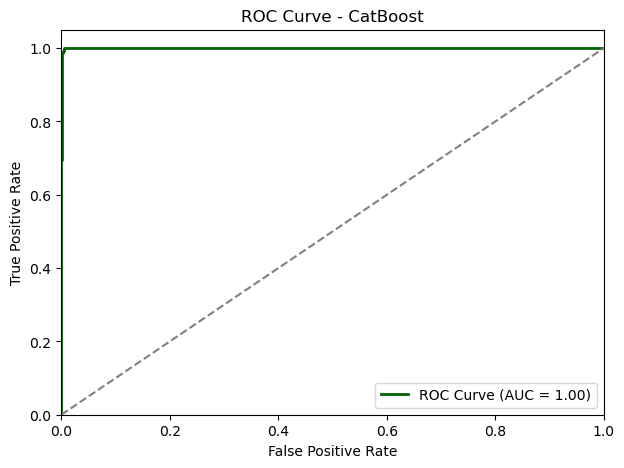

In [67]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Scale features for CatBoost (optional)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train CatBoost Classifier with tuned hyperparameters
catboost = CatBoostClassifier(
    iterations=1000,  # Increase iterations for better learning
    depth=8,  # Deeper trees capture complex patterns
    learning_rate=0.03,  # Lower learning rate for better convergence
    l2_leaf_reg=5,  # L2 regularization to reduce overfitting
    subsample=0.7,  # Use 70% of data per tree
    colsample_bylevel=0.8,  # Feature subsampling for regularization
    auto_class_weights="Balanced",  # Handles class imbalance automatically
    verbose=0,
    random_state=42
)

catboost.fit(X_train_scaled, y_train, early_stopping_rounds=20, eval_set=[(X_test_scaled, y_test)], verbose=False)
y_pred_catboost = catboost.predict(X_test_scaled)
y_pred_proba_catboost = catboost.predict_proba(X_test_scaled)[:, 1]  # Get probability for the positive class

# Classification Report
print("\nClassification Report - CatBoost:\n")
print(classification_report(y_test, y_pred_catboost))
# Train & Test Accuracy
train_acc_catboost = catboost.score(X_train_scaled, y_train)
test_acc_catboost = catboost.score(X_test_scaled, y_test)
print(f"Train Accuracy: {train_acc_catboost:.4f}")
print(f"Test Accuracy: {test_acc_catboost:.4f}")

# Confusion Matrix with different colormap
cm_catboost = confusion_matrix(y_test, y_pred_catboost)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_catboost, annot=True, fmt='d', cmap='magma', linewidths=1.5, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("CatBoost")
plt.show()

# ROC Curve
fpr_catboost, tpr_catboost, _ = roc_curve(y_test, y_pred_proba_catboost)
roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

plt.figure(figsize=(7, 5))
plt.plot(fpr_catboost, tpr_catboost, color='darkgreen', lw=2, label=f'ROC Curve (AUC = {roc_auc_catboost:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend(loc="lower right")
plt.show()

In [68]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Set up StratifiedKFold with 10 splits
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Track accuracies for each fold
fold_accuracies = []

# Go through each fold manually
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train), 1):
    # Split data into training and validation sets for this fold
    X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the CatBoost model on the current fold
    catboost.fit(X_fold_train, y_fold_train, early_stopping_rounds=20, eval_set=[(X_fold_val, y_fold_val)], verbose=False)

    # Make predictions and evaluate accuracy
    y_pred = catboost.predict(X_fold_val)
    accuracy = accuracy_score(y_fold_val, y_pred)
    fold_accuracies.append(accuracy)

    # Print results for this fold
    print(f" Fold {fold}: Cross Validation Accuracy = {accuracy:.4f}")

# Final average accuracy across all folds
print(f"\n Average Cross Validation Accuracy across 10 folds: {sum(fold_accuracies) / len(fold_accuracies):.4f}")

 Fold 1: Cross Validation Accuracy = 0.9730
 Fold 2: Cross Validation Accuracy = 0.9743
 Fold 3: Cross Validation Accuracy = 0.9781
 Fold 4: Cross Validation Accuracy = 0.9653
 Fold 5: Cross Validation Accuracy = 0.9820
 Fold 6: Cross Validation Accuracy = 0.9871
 Fold 7: Cross Validation Accuracy = 0.9743
 Fold 8: Cross Validation Accuracy = 0.9730
 Fold 9: Cross Validation Accuracy = 0.9653
 Fold 10: Cross Validation Accuracy = 0.9794

 Average Cross Validation Accuracy across 10 folds: 0.9752


# MLP (Multi-Layer Perceptron)


Classification Report - Multi-Layer Perceptron:

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       975
           1       0.95      1.00      0.97       970

    accuracy                           0.97      1945
   macro avg       0.97      0.97      0.97      1945
weighted avg       0.97      0.97      0.97      1945

Train Accuracy: 0.9967
Test Accuracy: 0.9728


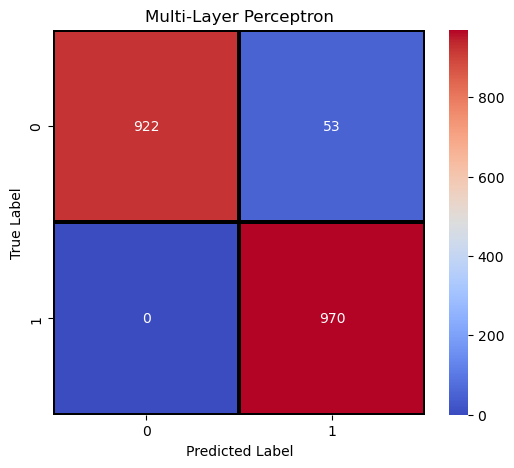

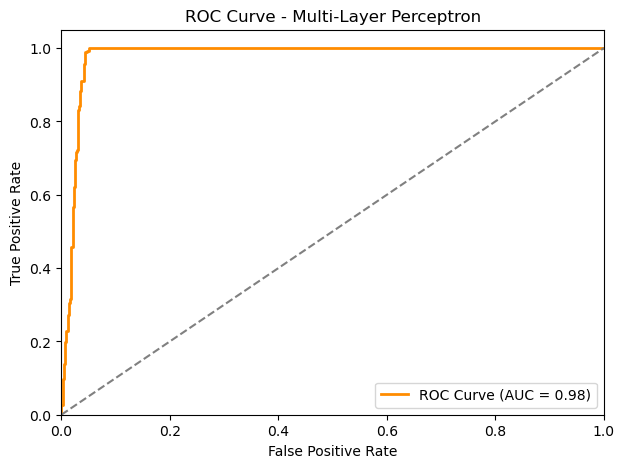

In [70]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Scale features (important for MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MLP Classifier
mlp1 = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # 3 hidden layers with 128, 64, and 32 neurons
    activation='relu',  # ReLU activation for non-linearity
    solver='adam',  # Adam optimizer
    alpha=0.0001,  # L2 regularization to prevent overfitting
    learning_rate='adaptive',  # Adjusts learning rate dynamically
    max_iter=500,  # Maximum training iterations
    random_state=42
)

mlp1.fit(X_train_scaled, y_train)
y_pred_mlp = mlp1.predict(X_test_scaled)
y_pred_proba_mlp = mlp1.predict_proba(X_test_scaled)[:, 1]  # Get probability for ROC

# Classification Report
print("\nClassification Report - Multi-Layer Perceptron:\n")
print(classification_report(y_test, y_pred_mlp))
# Train & Test Accuracy
train_acc_mlp = mlp1.score(X_train_scaled, y_train)
test_acc_mlp = mlp1.score(X_test_scaled, y_test)
print(f"Train Accuracy: {train_acc_mlp:.4f}")
print(f"Test Accuracy: {test_acc_mlp:.4f}")

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='coolwarm', linewidths=1.5, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multi-Layer Perceptron")
plt.show()

# ROC Curve
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_proba_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(7, 5))
plt.plot(fpr_mlp, tpr_mlp ,color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Layer Perceptron')
plt.legend(loc="lower right")
plt.show()

In [71]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Scale features (important for MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MLP Classifier
mlp2 = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    max_iter=500,
    early_stopping=True,  # Stop when validation loss stops improving
    validation_fraction=0.1,  # Use 10% of training data for validation
    random_state=42
)

mlp2.fit(X_train_scaled, y_train)
y_pred_mlp = mlp2.predict(X_test_scaled)
y_pred_proba_mlp = mlp2.predict_proba(X_test_scaled)[:, 1]  # Get probability for ROC

# Classification Report
print("\nClassification Report - Multi-Layer Perceptron:\n")
print(classification_report(y_test, y_pred_mlp))
# Train & Test Accuracy
train_acc_mlp = mlp2.score(X_train_scaled, y_train)
test_acc_mlp = mlp2.score(X_test_scaled, y_test)
print(f"Train Accuracy: {train_acc_mlp:.4f}")
print(f"Test Accuracy: {test_acc_mlp:.4f}")



Classification Report - Multi-Layer Perceptron:

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       975
           1       0.94      0.99      0.96       970

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945

Train Accuracy: 0.9769
Test Accuracy: 0.9630



Classification Report - Multi-Layer Perceptron:

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       975
           1       0.93      1.00      0.97       970

    accuracy                           0.97      1945
   macro avg       0.97      0.97      0.97      1945
weighted avg       0.97      0.97      0.96      1945

 Train Accuracy: 0.9892
 Test Accuracy: 0.9650


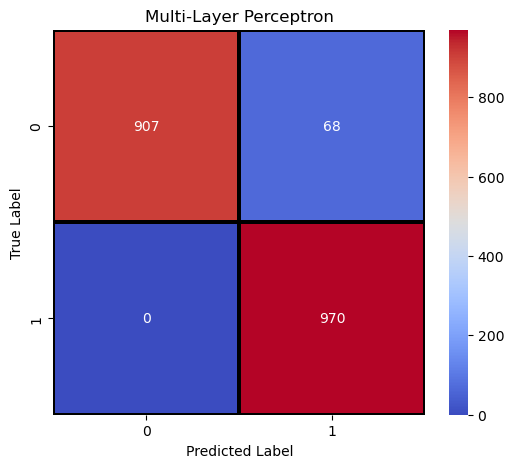

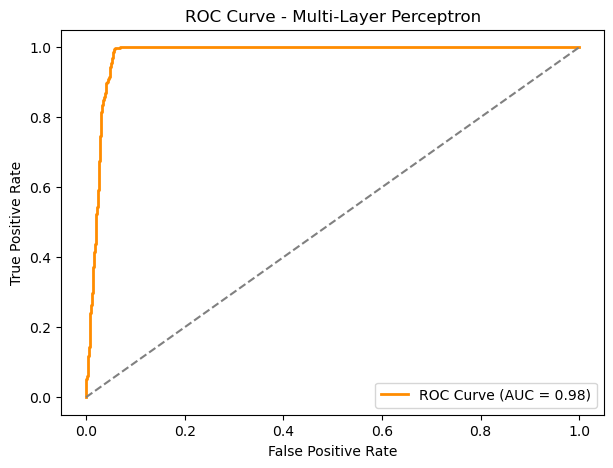

In [72]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Scale features (important for MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Train MLP Classifier (new architecture)
mlp4 = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # New 3-layer architecture
    activation='relu',
    solver='adam',
    alpha=0.002,  # Stronger L2 regularization
    learning_rate='adaptive',
    max_iter=500,
    early_stopping=True,  # Stop when validation loss stops improving
    validation_fraction=0.1,  # Use 10% of training data for validation
    random_state=42
)

# Fit the model
mlp4.fit(X_train_scaled, y_train)

# Make predictions
y_pred_mlp = mlp4.predict(X_test_scaled)
y_pred_proba_mlp = mlp4.predict_proba(X_test_scaled)[:, 1]

#  Classification Report
print("\nClassification Report - Multi-Layer Perceptron:\n")
print(classification_report(y_test, y_pred_mlp))

#  Train & Test Accuracy
train_acc_mlp = mlp4.score(X_train_scaled, y_train)
test_acc_mlp = mlp4.score(X_test_scaled, y_test)
print(f" Train Accuracy: {train_acc_mlp:.4f}")
print(f" Test Accuracy: {test_acc_mlp:.4f}")

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='coolwarm', linewidths=1.5, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multi-Layer Perceptron")
plt.show()

#  ROC Curve
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_proba_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(7, 5))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Layer Perceptron')
plt.legend(loc="lower right")
plt.show()


Classification Report - Multi-Layer Perceptron:

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       975
           1       0.93      1.00      0.96       970

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945

 Train Accuracy: 0.9857
 Test Accuracy: 0.9604


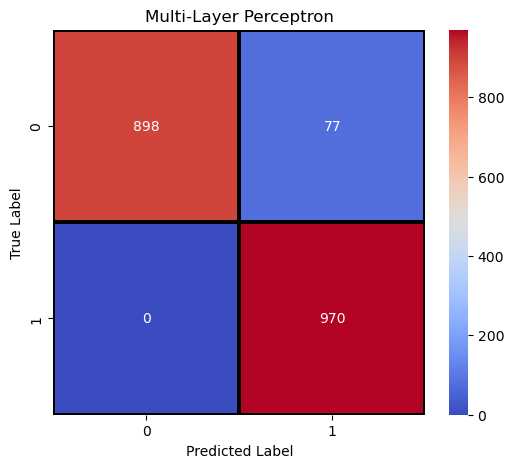

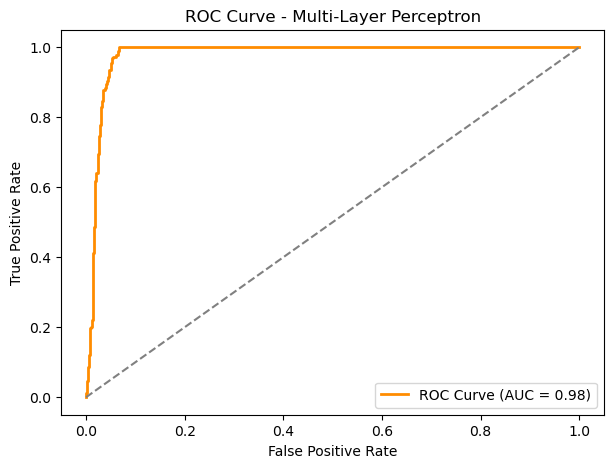

In [73]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Scale features (important for MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Train MLP Classifier (new architecture)
mlp5 = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),  # New 3-layer architecture
    activation='relu',
    solver='adam',
    alpha=0.002,  # Stronger L2 regularization
    learning_rate='adaptive',
    max_iter=500,
    early_stopping=True,  # Stop when validation loss stops improving
    validation_fraction=0.1,  # Use 10% of training data for validation
    random_state=42
)

# Fit the model
mlp5.fit(X_train_scaled, y_train)

# Make predictions
y_pred_mlp = mlp5.predict(X_test_scaled)
y_pred_proba_mlp = mlp5.predict_proba(X_test_scaled)[:, 1]

#  Classification Report
print("\nClassification Report - Multi-Layer Perceptron:\n")
print(classification_report(y_test, y_pred_mlp))

#  Train & Test Accuracy
train_acc_mlp = mlp5.score(X_train_scaled, y_train)
test_acc_mlp = mlp5.score(X_test_scaled, y_test)
print(f" Train Accuracy: {train_acc_mlp:.4f}")
print(f" Test Accuracy: {test_acc_mlp:.4f}")

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='coolwarm', linewidths=1.5, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multi-Layer Perceptron")
plt.show()

#  ROC Curve
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_proba_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(7, 5))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Layer Perceptron')
plt.legend(loc="lower right")
plt.show() 


Classification Report - Further Tuned Multi-Layer Perceptron (v3):

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       975
           1       0.93      1.00      0.96       970

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945

 Train Accuracy: 0.9919
 Test Accuracy: 0.9620


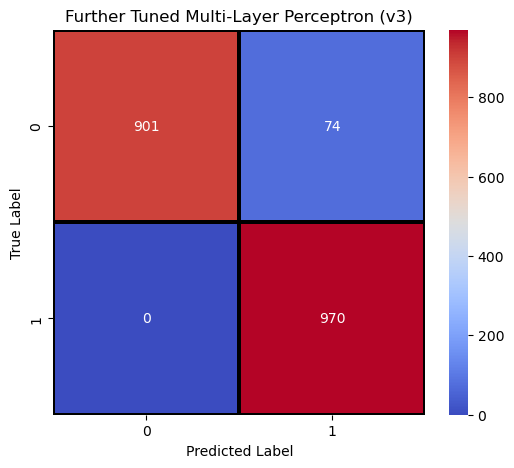

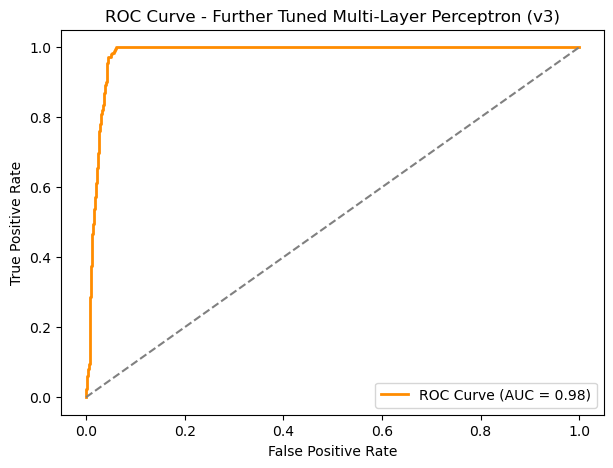

In [74]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Further Tuned MLP Classifier
mlp_tuned_v3 = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),  # Smaller architecture
    activation='tanh',  # Alternative activation function
    solver='adam',
    alpha=0.02,  # Stronger L2 regularization
    learning_rate='adaptive',
    learning_rate_init=0.0003,  # Slower learning rate
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=25,  # More patience for early stopping
    validation_fraction=0.1,
    random_state=42
)

# Fit the model
mlp_tuned_v3.fit(X_train_scaled, y_train)

# Make predictions
y_pred_mlp_tuned_v3 = mlp_tuned_v3.predict(X_test_scaled)
y_pred_proba_mlp_tuned_v3 = mlp_tuned_v3.predict_proba(X_test_scaled)[:, 1]

# Classification Report
print("\nClassification Report - Further Tuned Multi-Layer Perceptron (v3):\n")
print(classification_report(y_test, y_pred_mlp_tuned_v3))

# Train & Test Accuracy
train_acc_mlp_tuned_v3 = mlp_tuned_v3.score(X_train_scaled, y_train)
test_acc_mlp_tuned_v3 = mlp_tuned_v3.score(X_test_scaled, y_test)
print(f" Train Accuracy: {train_acc_mlp_tuned_v3:.4f}")
print(f" Test Accuracy: {test_acc_mlp_tuned_v3:.4f}")

# Confusion Matrix
cm_mlp_tuned_v3 = confusion_matrix(y_test, y_pred_mlp_tuned_v3)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mlp_tuned_v3, annot=True, fmt='d', cmap='coolwarm', linewidths=1.5, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Further Tuned Multi-Layer Perceptron (v3)")
plt.show()

# ROC Curve
fpr_mlp_tuned_v3, tpr_mlp_tuned_v3, _ = roc_curve(y_test, y_pred_proba_mlp_tuned_v3)
roc_auc_mlp_tuned_v3 = auc(fpr_mlp_tuned_v3, tpr_mlp_tuned_v3)

plt.figure(figsize=(7, 5))
plt.plot(fpr_mlp_tuned_v3, tpr_mlp_tuned_v3, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_mlp_tuned_v3:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Further Tuned Multi-Layer Perceptron (v3)')
plt.legend(loc="lower right")
plt.show()

In [75]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

# Set up 10-fold Stratified Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Track fold accuracies
fold_accuracies = []

# Loop through each fold manually
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train), 1):
    # Split data for this fold
    X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train on this fold
    mlp5.fit(X_fold_train, y_fold_train)

    # Evaluate performance on this fold’s validation set
    y_fold_pred = mlp5.predict(X_fold_val)
    accuracy = accuracy_score(y_fold_val, y_fold_pred)
    fold_accuracies.append(accuracy)

    # Print accuracy for this fold
    print(f" Fold {fold}: Cross-Validation Accuracy = {accuracy:.4f}")

# Final average accuracy across all folds
print(f"\n Average Cross-Validation Accuracy: {sum(fold_accuracies) / len(fold_accuracies):.4f}") 

 Fold 1: Cross-Validation Accuracy = 0.9730
 Fold 2: Cross-Validation Accuracy = 0.9396
 Fold 3: Cross-Validation Accuracy = 0.9704
 Fold 4: Cross-Validation Accuracy = 0.9486
 Fold 5: Cross-Validation Accuracy = 0.9614
 Fold 6: Cross-Validation Accuracy = 0.9576
 Fold 7: Cross-Validation Accuracy = 0.9614
 Fold 8: Cross-Validation Accuracy = 0.9562
 Fold 9: Cross-Validation Accuracy = 0.9704
 Fold 10: Cross-Validation Accuracy = 0.9614

 Average Cross-Validation Accuracy: 0.9600


# Store All Model Results

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_scores = {
    "Logistic Regression": {
        "Accuracy": accuracy_score(y_test, y_pred_logreg),
        "Precision": precision_score(y_test, y_pred_logreg, average="weighted"),
        "Recall": recall_score(y_test, y_pred_logreg, average="weighted"),
        "F1-Score": f1_score(y_test, y_pred_logreg, average="weighted"),
    },
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Precision": precision_score(y_test, y_pred_rf, average="weighted"),
        "Recall": recall_score(y_test, y_pred_rf, average="weighted"),
        "F1-Score": f1_score(y_test, y_pred_rf, average="weighted"),
    },
    "Support Vector Machine": {
        "Accuracy": accuracy_score(y_test, y_pred_svm),
        "Precision": precision_score(y_test, y_pred_svm, average="weighted"),
        "Recall": recall_score(y_test, y_pred_svm, average="weighted"),
        "F1-Score": f1_score(y_test, y_pred_svm, average="weighted"),
    },
    "Decision Tree": {
        "Accuracy": accuracy_score(y_test, y_pred_dt),
        "Precision": precision_score(y_test, y_pred_dt, average="weighted"),
        "Recall": recall_score(y_test, y_pred_dt, average="weighted"),
        "F1-Score": f1_score(y_test, y_pred_dt, average="weighted"),
    },
    "K-Nearest Neighbors": {
        "Accuracy": accuracy_score(y_test, y_pred_knn),
        "Precision": precision_score(y_test, y_pred_knn, average="weighted"),
        "Recall": recall_score(y_test, y_pred_knn, average="weighted"),
        "F1-Score": f1_score(y_test, y_pred_knn, average="weighted"),
    },
    "XGBoost": {
        "Accuracy": accuracy_score(y_test, y_pred_xgb),
        "Precision": precision_score(y_test, y_pred_xgb, average="weighted"),
        "Recall": recall_score(y_test, y_pred_xgb, average="weighted"),
        "F1-Score": f1_score(y_test, y_pred_xgb, average="weighted"),
    },
    "CatBoost": {
        "Accuracy": accuracy_score(y_test, y_pred_catboost),
        "Precision": precision_score(y_test, y_pred_catboost, average="weighted"),
        "Recall": recall_score(y_test, y_pred_catboost, average="weighted"),
        "F1-Score": f1_score(y_test, y_pred_catboost, average="weighted"),
    },
    "Multi-Layer Perceptron": {
        "Accuracy": accuracy_score(y_test, y_pred_mlp),
        "Precision": precision_score(y_test, y_pred_mlp, average="weighted"),
        "Recall": recall_score(y_test, y_pred_mlp, average="weighted"),
        "F1-Score": f1_score(y_test, y_pred_mlp, average="weighted"),
    }
}

# Print results
for model, scores in model_scores.items():
    print(f"\n{model} Performance:")
    for metric, value in scores.items():
        print(f"{metric}: {value:.4f}")



Logistic Regression Performance:
Accuracy: 0.7568
Precision: 0.7577
Recall: 0.7568
F1-Score: 0.7566

Random Forest Performance:
Accuracy: 0.9969
Precision: 0.9969
Recall: 0.9969
F1-Score: 0.9969

Support Vector Machine Performance:
Accuracy: 0.7923
Precision: 0.7985
Recall: 0.7923
F1-Score: 0.7912

Decision Tree Performance:
Accuracy: 0.8612
Precision: 0.8639
Recall: 0.8612
F1-Score: 0.8609

K-Nearest Neighbors Performance:
Accuracy: 0.8560
Precision: 0.8883
Recall: 0.8560
F1-Score: 0.8531

XGBoost Performance:
Accuracy: 0.9779
Precision: 0.9788
Recall: 0.9779
F1-Score: 0.9779

CatBoost Performance:
Accuracy: 0.9820
Precision: 0.9826
Recall: 0.9820
F1-Score: 0.9820

Multi-Layer Perceptron Performance:
Accuracy: 0.9604
Precision: 0.9633
Recall: 0.9604
F1-Score: 0.9604


# Compare Performance Using Bar Plot

<Figure size 1000x600 with 0 Axes>

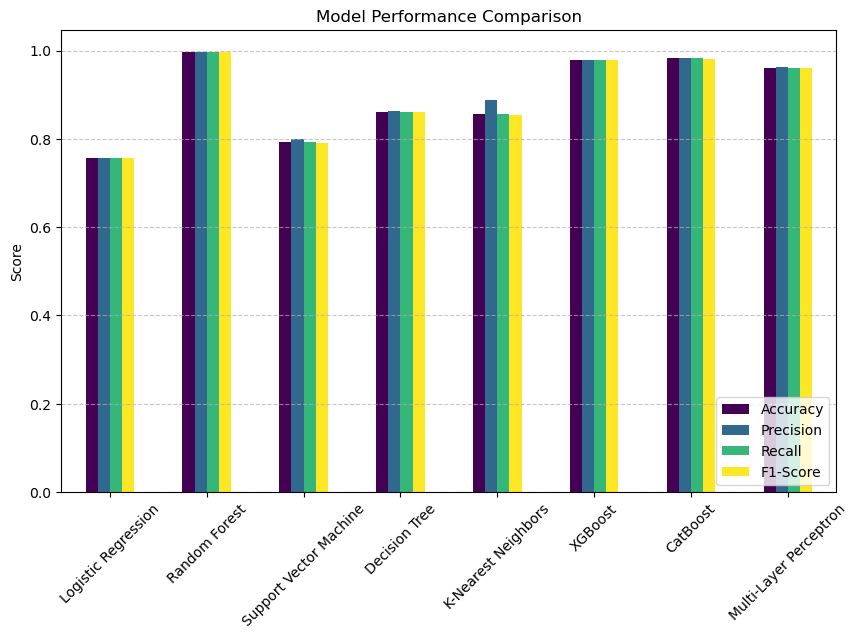

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert dictionary to DataFrame for visualization
scores_df = pd.DataFrame(model_scores).T  # Transpose for readability

# Plot comparison
plt.figure(figsize=(10, 6))
scores_df.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# Pick The Best Model

In [81]:
# Convert the model_scores dictionary into a DataFrame
scores_df = pd.DataFrame(model_scores).T  # Transpose for better readability
print(scores_df)

# Select the model with the highest F1-score
best_model_name = scores_df["F1-Score"].idxmax()
print(f"\n Best Model Selected: {best_model_name}")

# Assign the best model to a variable
best_model = {
    "Logistic Regression": logreg,
    "Random Forest": rf,
    "Support Vector Machine": svm,
    "Decision Tree": dt,
    "KNN": knn,
    "XGBoost": xgb,
    "CatBoost": catboost,
    "MLP (Neural Network)": mlp4
}[best_model_name]


                        Accuracy  Precision    Recall  F1-Score
Logistic Regression     0.756812   0.757672  0.756812  0.756635
Random Forest           0.996915   0.996934  0.996915  0.996915
Support Vector Machine  0.792288   0.798547  0.792288  0.791245
Decision Tree           0.861183   0.863927  0.861183  0.860939
K-Nearest Neighbors     0.856041   0.888288  0.856041  0.853051
XGBoost                 0.977892   0.978830  0.977892  0.977882
CatBoost                0.982005   0.982632  0.982005  0.982000
Multi-Layer Perceptron  0.960411   0.963323  0.960411  0.960353

 Best Model Selected: Random Forest


# Save The Model

In [83]:
import joblib

# Save the model
joblib.dump(best_model, "best_model(Random Forest).pkl")
print(f"\n Best model ({best_model_name}) saved as 'best_model.pkl'")



 Best model (Random Forest) saved as 'best_model.pkl'


# SHAP-Visualization

In [85]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(X_test)

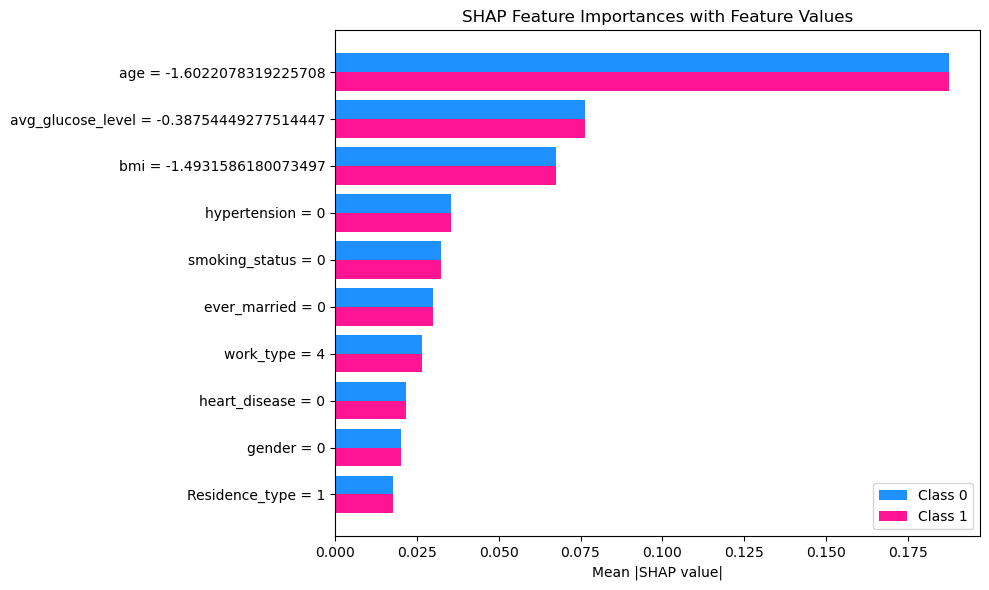

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feature_names = ["gender", "age", "hypertension", "heart_disease", "ever_married", "work_type",
                 "Residence_type", "avg_glucose_level", "bmi", "smoking_status" , "stroke" ]

X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Get mean(|SHAP|) per feature per class
mean_abs_shap_class0 = np.abs(shap_values[:, :, 0]).mean(axis=0)
mean_abs_shap_class1 = np.abs(shap_values[:, :, 1]).mean(axis=0)

# Choose top N features based on class 1 importance
topn = 15
top_indices = np.argsort(mean_abs_shap_class1)[::-1][:topn]

feature_labels = [
    f"{feature_names[i]} = {X_test_df.iloc[0, i]}" for i in top_indices
]

# Bar plot
index = np.arange(len(top_indices))
bar_width = 0.4

plt.figure(figsize=(10, 6))
plt.barh(index, [mean_abs_shap_class0[i] for i in top_indices], bar_width, color='dodgerblue', label='Class 0')
plt.barh(index + bar_width, [mean_abs_shap_class1[i] for i in top_indices], bar_width, color='deeppink', label='Class 1')

plt.yticks(index + bar_width / 2, feature_labels)
plt.xlabel("Mean |SHAP value|")
plt.title("SHAP Feature Importances with Feature Values")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Dependence plot

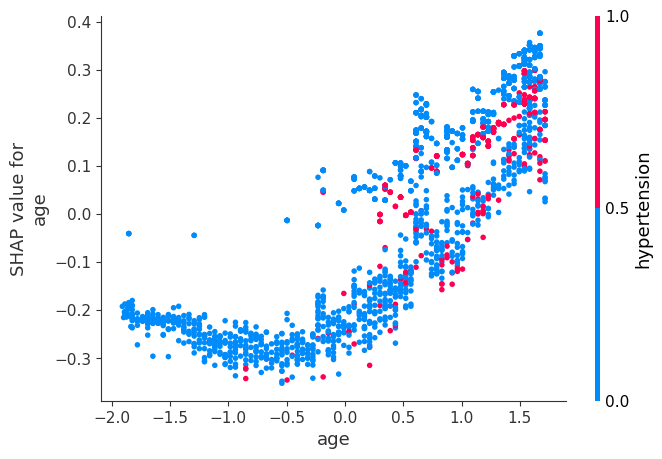

In [88]:
shap.dependence_plot("age", shap_values[:, :, 1], X_test, interaction_index="hypertension"  )

# Force-plot for class 0

In [90]:
i = 0  
class_idx = 0

shap.force_plot(
    base_value=explainer.expected_value[class_idx],
    shap_values=shap_values[i][:, class_idx],
    features=X_test.iloc[i]
)


# Force-plot for class 1

In [92]:
i = 0 
class_idx = 1 

shap.plots.force(
    base_value=explainer.expected_value[class_idx],
    shap_values=shap_values[i][:, class_idx],  
    features=X_test.iloc[i])

# Decision-plot

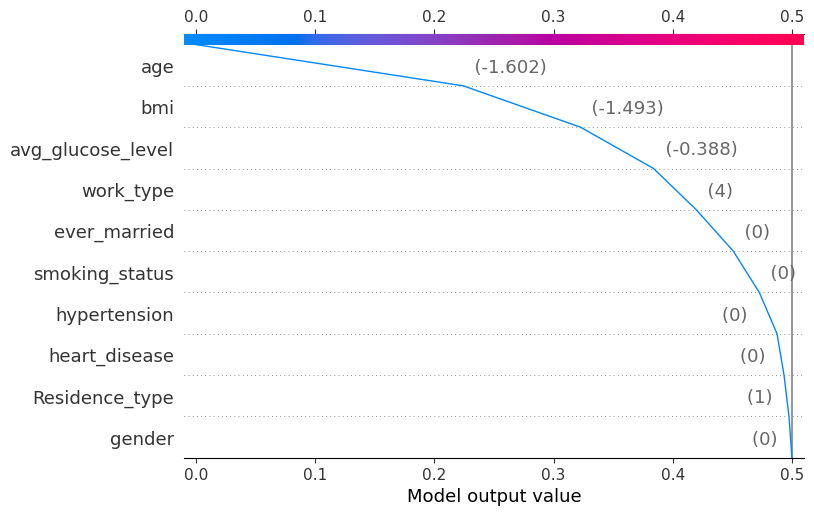

In [94]:
i = 0 

shap.decision_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_values[i][:, 1],           
    features=X_test.iloc[i],                 
    feature_names=list(X_test.columns)       
)


# Merge Random-Forest & CatBoost model


Classification Report - Ensemble Model (RandomForest + CatBoost):

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       975
           1       0.98      1.00      0.99       970

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945

Accuracy: 0.9892
Train Accuracy: 0.9999
Test Accuracy: 0.9892


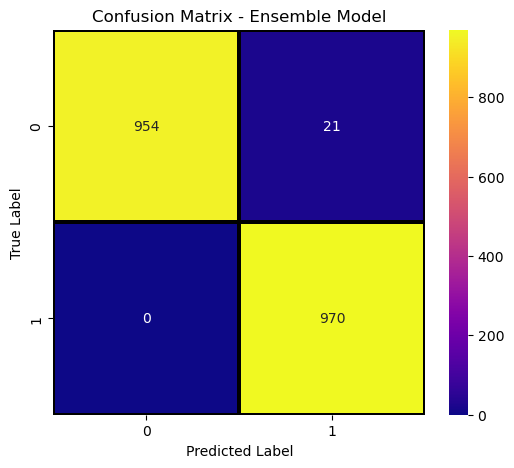

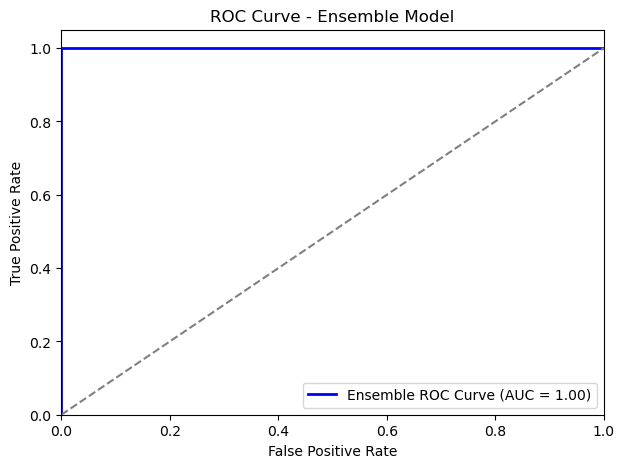

In [96]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# Standardize the data for CatBoost (optional for RandomForest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define individual models
rf_c = RandomForestClassifier(n_estimators=100, random_state=42)

catboost_1 = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=5,
    subsample=0.7,
    colsample_bylevel=0.8,
    auto_class_weights="Balanced",
    verbose=0,
    random_state=42
)

# Voting Classifier (Soft Voting)
voting_clf = VotingClassifier( estimators=[ ('rf_c', rf_c), ('catboost_1', catboost_1) ], voting='soft')

# Fit the ensemble model
voting_clf.fit(X_train_scaled, y_train)

# Predictions and probabilities
y_pred_ensemble = voting_clf.predict(X_test_scaled)
y_pred_prob_ensemble = voting_clf.predict_proba(X_test_scaled)[:, 1]

# Classification Report
print("\nClassification Report - Ensemble Model (RandomForest + CatBoost):\n")
print(classification_report(y_test, y_pred_ensemble))
print(f'Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}')

# Train & Test Accuracy
train_acc = voting_clf.score(X_train_scaled, y_train)
test_acc = voting_clf.score(X_test_scaled, y_test)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='plasma', linewidths=1.5, linecolor='black')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Ensemble Model")
plt.show()

# ROC Curve
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_pred_prob_ensemble)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

plt.figure(figsize=(7, 5))
plt.plot(fpr_ensemble, tpr_ensemble, color='blue', lw=2,
         label=f'Ensemble ROC Curve (AUC = {roc_auc_ensemble:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Model')
plt.legend(loc="lower right")
plt.show()

In [97]:
from sklearn.model_selection import StratifiedKFold

# K-Fold Cross Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train), 1):
    X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Fit ensemble model on this fold
    voting_clf.fit(X_fold_train, y_fold_train)

    # Predict and calculate accuracy
    y_pred_fold = voting_clf.predict(X_fold_val)
    acc = accuracy_score(y_fold_val, y_pred_fold)
    fold_accuracies.append(acc)

    print(f" Fold {fold}: Cross-Validation Accuracy = {acc:.4f}")

# Final average accuracy
avg_acc = np.mean(fold_accuracies)
print(f"\n Average Cross-Validation Accuracy across 10 folds: {avg_acc:.4f}")


 Fold 1: Cross-Validation Accuracy = 0.9820
 Fold 2: Cross-Validation Accuracy = 0.9781
 Fold 3: Cross-Validation Accuracy = 0.9897
 Fold 4: Cross-Validation Accuracy = 0.9781
 Fold 5: Cross-Validation Accuracy = 0.9833
 Fold 6: Cross-Validation Accuracy = 0.9910
 Fold 7: Cross-Validation Accuracy = 0.9769
 Fold 8: Cross-Validation Accuracy = 0.9794
 Fold 9: Cross-Validation Accuracy = 0.9743
 Fold 10: Cross-Validation Accuracy = 0.9807

 Average Cross-Validation Accuracy across 10 folds: 0.9814


# SHAP plot

In [99]:
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_test_scaled)

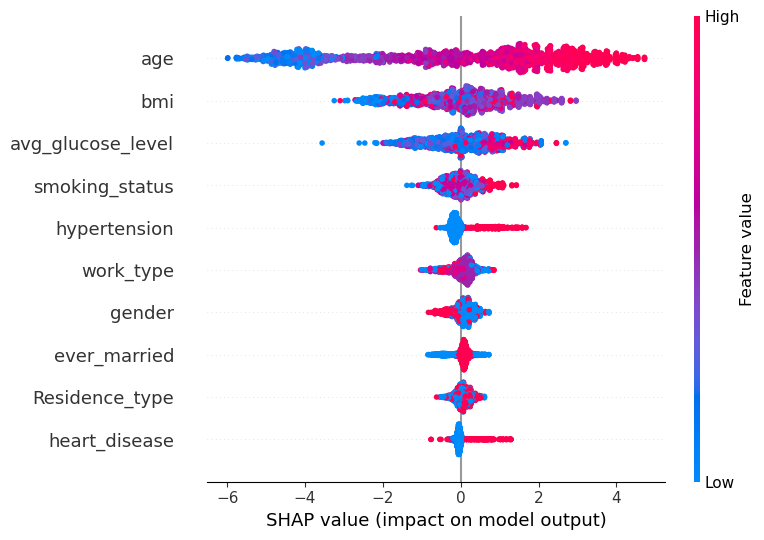

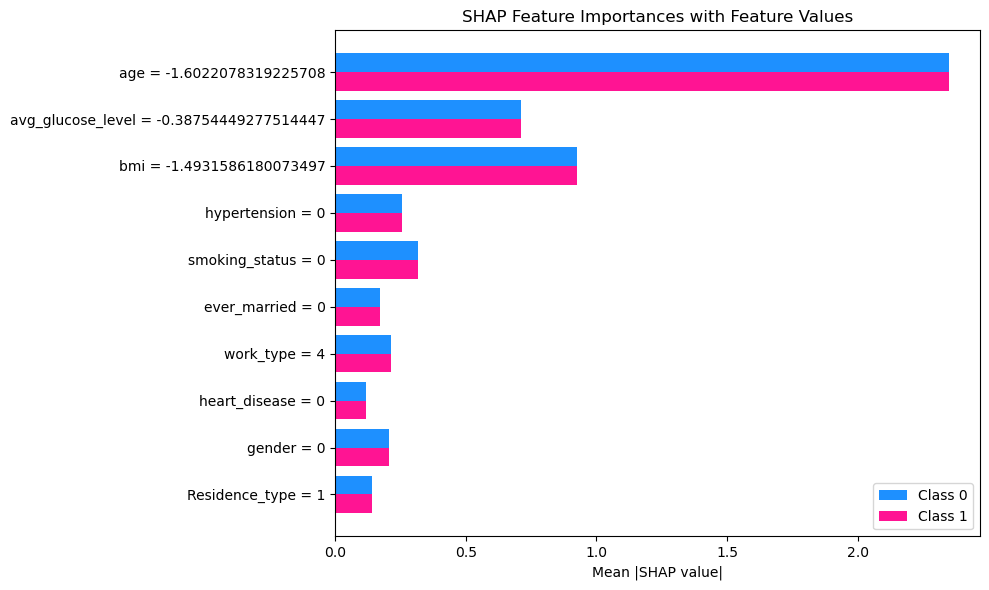

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feature_names = ["gender", "age", "hypertension", "heart_disease", "ever_married", "work_type",
                 "Residence_type", "avg_glucose_level", "bmi", "smoking_status" , "stroke" ]

X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Get mean(|SHAP|) per feature per class
mean_abs_shap_class0 = np.abs(shap_values).mean(axis=0)  # Class 0 (average over samples)
mean_abs_shap_class1 = np.abs(shap_values).mean(axis=0)  # Class 1 (average over samples)

# Choose top N features based on importance for class 1
top_n_features_class1 = np.argsort(mean_abs_shap_class1)[-10:]

# Plot the SHAP summary plot for class 1 importance
shap.summary_plot(shap_values[:, top_n_features_class1], X_test_df.iloc[:, top_n_features_class1], feature_names=X_test_df.columns[top_n_features_class1])

feature_labels = [
    f"{feature_names[i]} = {X_test_df.iloc[0, i]}" for i in top_indices
]

# Bar plot
index = np.arange(len(top_indices))
bar_width = 0.4

plt.figure(figsize=(10, 6))
plt.barh(index, [mean_abs_shap_class0[i] for i in top_indices], bar_width, color='dodgerblue', label='Class 0')
plt.barh(index + bar_width, [mean_abs_shap_class1[i] for i in top_indices], bar_width, color='deeppink', label='Class 1')

plt.yticks(index + bar_width / 2, feature_labels)
plt.xlabel("Mean |SHAP value|")
plt.title("SHAP Feature Importances with Feature Values")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Dependence plot

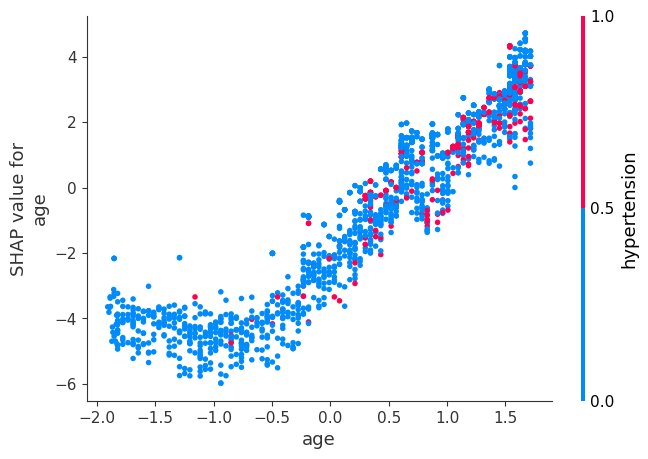

In [102]:
import shap

# Correct the SHAP dependence plot
shap.dependence_plot("age", shap_values, X_test, interaction_index="hypertension")


# Force plot

In [104]:
i = 0  # index of the sample you want to explain

shap.force_plot(
    base_value=explainer.expected_value,          # scalar base value
    shap_values=shap_values[i],                   # SHAP values for the i-th sample
    features=X_test.iloc[i],                      # feature values for the i-th sample
    feature_names=X_test.columns,                 # names of the features
    contribution_threshold=0                      # show all features
)


# Decision plot

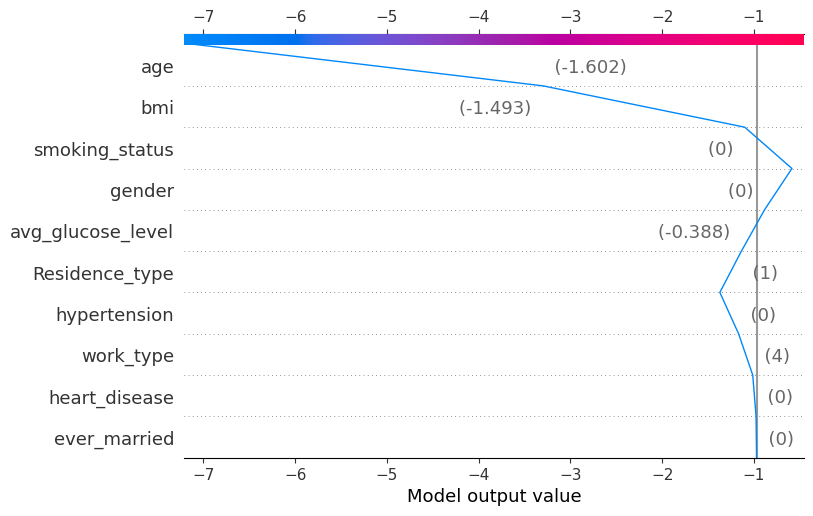

In [106]:
i = 0  # index of the sample

shap.decision_plot(
    base_value=explainer.expected_value,           # Don't index it
    shap_values=shap_values[i],                    # SHAP values for sample i
    features=X_test.iloc[i],                       # feature values for sample i
    feature_names=list(X_test.columns)             # feature names
)


# Remove imp Feature to check Impact on Accuracy 

# After Removing Age

In [182]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_c = RandomForestClassifier(n_estimators=100, random_state=42)

catboost_1 = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=5,
    subsample=0.7,
    colsample_bylevel=0.8,
    auto_class_weights="Balanced",
    verbose=0,
    random_state=42)


voting_clf = VotingClassifier(estimators=[('rf_c', rf_c), ('catboost_1', catboost_1) ], voting='soft')

important_feature = 'age'
X_train_reduced = X_train.drop(columns=[important_feature])
X_test_reduced = X_test.drop(columns=[important_feature])

X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

voting_clf.fit(X_train_reduced_scaled, y_train)

y_pred_reduced = voting_clf.predict(X_test_reduced_scaled)
y_pred_prob_reduced = voting_clf.predict_proba(X_test_reduced_scaled)[:, 1]

print("\nClassification Report\n")
print(classification_report(y_test, y_pred_reduced))
print(f"Accuracy: {accuracy_score(y_test, y_pred_reduced):.4f}")

train_acc_reduced = voting_clf.score(X_train_reduced_scaled, y_train)
test_acc_reduced = voting_clf.score(X_test_reduced_scaled, y_test)

print(f"Train Accuracy: {train_acc_reduced:.4f}")
print(f"Test Accuracy: {test_acc_reduced:.4f}")



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       975
           1       0.97      1.00      0.99       970

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945

Accuracy: 0.9861
Train Accuracy: 0.9990
Test Accuracy: 0.9861


# After Removing avg_glucose_level

In [184]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_c = RandomForestClassifier(n_estimators=100, random_state=42)

catboost_1 = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=5,
    subsample=0.7,
    colsample_bylevel=0.8,
    auto_class_weights="Balanced",
    verbose=0,
    random_state=42)


voting_clf = VotingClassifier(estimators=[('rf_c', rf_c), ('catboost_1', catboost_1) ], voting='soft')

important_feature = 'avg_glucose_level'

X_train_reduced = X_train.drop(columns=[important_feature])
X_test_reduced = X_test.drop(columns=[important_feature])

X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

voting_clf.fit(X_train_reduced_scaled, y_train)

y_pred_reduced = voting_clf.predict(X_test_reduced_scaled)
y_pred_prob_reduced = voting_clf.predict_proba(X_test_reduced_scaled)[:, 1]

print("\nClassification Report\n")
print(classification_report(y_test, y_pred_reduced))
print(f"Accuracy: {accuracy_score(y_test, y_pred_reduced):.4f}")

train_acc_reduced = voting_clf.score(X_train_reduced_scaled, y_train)
test_acc_reduced = voting_clf.score(X_test_reduced_scaled, y_test)

print(f"Train Accuracy: {train_acc_reduced:.4f}")
print(f"Test Accuracy: {test_acc_reduced:.4f}")



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       975
           1       0.97      1.00      0.98       970

    accuracy                           0.98      1945
   macro avg       0.98      0.98      0.98      1945
weighted avg       0.98      0.98      0.98      1945

Accuracy: 0.9835
Train Accuracy: 0.9976
Test Accuracy: 0.9835


# After Removing bmi

In [186]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_c = RandomForestClassifier(n_estimators=100, random_state=42)

catboost_1 = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=5,
    subsample=0.7,
    colsample_bylevel=0.8,
    auto_class_weights="Balanced",
    verbose=0,
    random_state=42)

voting_clf = VotingClassifier(estimators=[('rf_c', rf_c), ('catboost_1', catboost_1) ], voting='soft')

important_feature = 'bmi'

X_train_reduced = X_train.drop(columns=[important_feature])
X_test_reduced = X_test.drop(columns=[important_feature])

X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

voting_clf.fit(X_train_reduced_scaled, y_train)

y_pred_reduced = voting_clf.predict(X_test_reduced_scaled)
y_pred_prob_reduced = voting_clf.predict_proba(X_test_reduced_scaled)[:, 1]

print("\nClassification Report\n")
print(classification_report(y_test, y_pred_reduced))
print(f"Accuracy: {accuracy_score(y_test, y_pred_reduced):.4f}")

train_acc_reduced = voting_clf.score(X_train_reduced_scaled, y_train)
test_acc_reduced = voting_clf.score(X_test_reduced_scaled, y_test)

print(f"Train Accuracy: {train_acc_reduced:.4f}")
print(f"Test Accuracy: {test_acc_reduced:.4f}")



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       975
           1       0.96      1.00      0.98       970

    accuracy                           0.98      1945
   macro avg       0.98      0.98      0.98      1945
weighted avg       0.98      0.98      0.98      1945

Accuracy: 0.9789
Train Accuracy: 0.9996
Test Accuracy: 0.9789


# After Removing hypertension

In [188]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_c = RandomForestClassifier(n_estimators=100, random_state=42)

catboost_1 = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=5,
    subsample=0.7,
    colsample_bylevel=0.8,
    auto_class_weights="Balanced",
    verbose=0,
    random_state=42)

voting_clf = VotingClassifier(estimators=[('rf_c', rf_c), ('catboost_1', catboost_1) ], voting='soft')

important_feature = 'hypertension'

X_train_reduced = X_train.drop(columns=[important_feature])
X_test_reduced = X_test.drop(columns=[important_feature])

X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

voting_clf.fit(X_train_reduced_scaled, y_train)

y_pred_reduced = voting_clf.predict(X_test_reduced_scaled)
y_pred_prob_reduced = voting_clf.predict_proba(X_test_reduced_scaled)[:, 1]

print("\nClassification Report\n")
print(classification_report(y_test, y_pred_reduced))
print(f"Accuracy: {accuracy_score(y_test, y_pred_reduced):.4f}")

train_acc_reduced = voting_clf.score(X_train_reduced_scaled, y_train)
test_acc_reduced = voting_clf.score(X_test_reduced_scaled, y_test)

print(f"Train Accuracy: {train_acc_reduced:.4f}")
print(f"Test Accuracy: {test_acc_reduced:.4f}")



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       975
           1       0.98      1.00      0.99       970

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945

Accuracy: 0.9897
Train Accuracy: 0.9999
Test Accuracy: 0.9897


# After Removing Smoking status

In [190]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_c = RandomForestClassifier(n_estimators=100, random_state=42)

catboost_1 = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=5,
    subsample=0.7,
    colsample_bylevel=0.8,
    auto_class_weights="Balanced",
    verbose=0,
    random_state=42)

voting_clf = VotingClassifier(estimators=[('rf_c', rf_c), ('catboost_1', catboost_1) ], voting='soft')

important_feature = 'smoking_status'

X_train_reduced = X_train.drop(columns=[important_feature])
X_test_reduced = X_test.drop(columns=[important_feature])

X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

voting_clf.fit(X_train_reduced_scaled, y_train)

y_pred_reduced = voting_clf.predict(X_test_reduced_scaled)
y_pred_prob_reduced = voting_clf.predict_proba(X_test_reduced_scaled)[:, 1]

print("\nClassification Report\n")
print(classification_report(y_test, y_pred_reduced))
print(f"Accuracy: {accuracy_score(y_test, y_pred_reduced):.4f}")

train_acc_reduced = voting_clf.score(X_train_reduced_scaled, y_train)
test_acc_reduced = voting_clf.score(X_test_reduced_scaled, y_test)

print(f"Train Accuracy: {train_acc_reduced:.4f}")
print(f"Test Accuracy: {test_acc_reduced:.4f}")



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       975
           1       0.97      1.00      0.99       970

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945

Accuracy: 0.9871
Train Accuracy: 0.9996
Test Accuracy: 0.9871


# After Removing ever_married

In [192]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_c = RandomForestClassifier(n_estimators=100, random_state=42)

catboost_1 = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=5,
    subsample=0.7,
    colsample_bylevel=0.8,
    auto_class_weights="Balanced",
    verbose=0,
    random_state=42)

voting_clf = VotingClassifier(estimators=[('rf_c', rf_c), ('catboost_1', catboost_1) ], voting='soft')

important_feature = 'ever_married'

X_train_reduced = X_train.drop(columns=[important_feature])
X_test_reduced = X_test.drop(columns=[important_feature])

X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

voting_clf.fit(X_train_reduced_scaled, y_train)

y_pred_reduced = voting_clf.predict(X_test_reduced_scaled)
y_pred_prob_reduced = voting_clf.predict_proba(X_test_reduced_scaled)[:, 1]

print("\nClassification Report\n")
print(classification_report(y_test, y_pred_reduced))
print(f"Accuracy: {accuracy_score(y_test, y_pred_reduced):.4f}")

train_acc_reduced = voting_clf.score(X_train_reduced_scaled, y_train)
test_acc_reduced = voting_clf.score(X_test_reduced_scaled, y_test)

print(f"Train Accuracy: {train_acc_reduced:.4f}")
print(f"Test Accuracy: {test_acc_reduced:.4f}")



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       975
           1       0.98      1.00      0.99       970

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945

Accuracy: 0.9902
Train Accuracy: 0.9996
Test Accuracy: 0.9902


# After Removing work_type

In [194]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_c = RandomForestClassifier(n_estimators=100, random_state=42)

catboost_1 = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=5,
    subsample=0.7,
    colsample_bylevel=0.8,
    auto_class_weights="Balanced",
    verbose=0,
    random_state=42)

voting_clf = VotingClassifier(estimators=[('rf_c', rf_c), ('catboost_1', catboost_1) ], voting='soft')

important_feature = 'work_type'

X_train_reduced = X_train.drop(columns=[important_feature])
X_test_reduced = X_test.drop(columns=[important_feature])

X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

voting_clf.fit(X_train_reduced_scaled, y_train)

y_pred_reduced = voting_clf.predict(X_test_reduced_scaled)
y_pred_prob_reduced = voting_clf.predict_proba(X_test_reduced_scaled)[:, 1]

print("\nClassification Report\n")
print(classification_report(y_test, y_pred_reduced))
print(f"Accuracy: {accuracy_score(y_test, y_pred_reduced):.4f}")

train_acc_reduced = voting_clf.score(X_train_reduced_scaled, y_train)
test_acc_reduced = voting_clf.score(X_test_reduced_scaled, y_test)

print(f"Train Accuracy: {train_acc_reduced:.4f}")
print(f"Test Accuracy: {test_acc_reduced:.4f}")



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       975
           1       0.97      1.00      0.99       970

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945

Accuracy: 0.9866
Train Accuracy: 0.9999
Test Accuracy: 0.9866


# After Removing heart disease

In [196]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_c = RandomForestClassifier(n_estimators=100, random_state=42)

catboost_1 = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=5,
    subsample=0.7,
    colsample_bylevel=0.8,
    auto_class_weights="Balanced",
    verbose=0,
    random_state=42)

voting_clf = VotingClassifier(estimators=[('rf_c', rf_c), ('catboost_1', catboost_1) ], voting='soft')

important_feature = 'heart_disease'

X_train_reduced = X_train.drop(columns=[important_feature])
X_test_reduced = X_test.drop(columns=[important_feature])

X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

voting_clf.fit(X_train_reduced_scaled, y_train)

y_pred_reduced = voting_clf.predict(X_test_reduced_scaled)
y_pred_prob_reduced = voting_clf.predict_proba(X_test_reduced_scaled)[:, 1]

print("\nClassification Report\n")
print(classification_report(y_test, y_pred_reduced))
print(f"Accuracy: {accuracy_score(y_test, y_pred_reduced):.4f}")

train_acc_reduced = voting_clf.score(X_train_reduced_scaled, y_train)
test_acc_reduced = voting_clf.score(X_test_reduced_scaled, y_test)

print(f"Train Accuracy: {train_acc_reduced:.4f}")
print(f"Test Accuracy: {test_acc_reduced:.4f}")



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       975
           1       0.98      1.00      0.99       970

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945

Accuracy: 0.9877
Train Accuracy: 0.9997
Test Accuracy: 0.9877


# After Removing gendre

In [198]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_c = RandomForestClassifier(n_estimators=100, random_state=42)

catboost_1 = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=5,
    subsample=0.7,
    colsample_bylevel=0.8,
    auto_class_weights="Balanced",
    verbose=0,
    random_state=42)

voting_clf = VotingClassifier(estimators=[('rf_c', rf_c), ('catboost_1', catboost_1) ], voting='soft')

important_feature = 'gender'

X_train_reduced = X_train.drop(columns=[important_feature])
X_test_reduced = X_test.drop(columns=[important_feature])

X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

voting_clf.fit(X_train_reduced_scaled, y_train)

y_pred_reduced = voting_clf.predict(X_test_reduced_scaled)
y_pred_prob_reduced = voting_clf.predict_proba(X_test_reduced_scaled)[:, 1]

print("\nClassification Report\n")
print(classification_report(y_test, y_pred_reduced))
print(f"Accuracy: {accuracy_score(y_test, y_pred_reduced):.4f}")

train_acc_reduced = voting_clf.score(X_train_reduced_scaled, y_train)
test_acc_reduced = voting_clf.score(X_test_reduced_scaled, y_test)

print(f"Train Accuracy: {train_acc_reduced:.4f}")
print(f"Test Accuracy: {test_acc_reduced:.4f}")



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       975
           1       0.97      1.00      0.99       970

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945

Accuracy: 0.9856
Train Accuracy: 0.9997
Test Accuracy: 0.9856


# After Removing Residence type

In [200]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_c = RandomForestClassifier(n_estimators=100, random_state=42)

catboost_1 = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.03,
    l2_leaf_reg=5,
    subsample=0.7,
    colsample_bylevel=0.8,
    auto_class_weights="Balanced",
    verbose=0,
    random_state=42)

voting_clf = VotingClassifier(estimators=[('rf_c', rf_c), ('catboost_1', catboost_1) ], voting='soft')

important_feature = 'Residence_type'

X_train_reduced = X_train.drop(columns=[important_feature])
X_test_reduced = X_test.drop(columns=[important_feature])

X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

voting_clf.fit(X_train_reduced_scaled, y_train)

y_pred_reduced = voting_clf.predict(X_test_reduced_scaled)
y_pred_prob_reduced = voting_clf.predict_proba(X_test_reduced_scaled)[:, 1]

print("\nClassification Report\n")
print(classification_report(y_test, y_pred_reduced))
print(f"Accuracy: {accuracy_score(y_test, y_pred_reduced):.4f}")

train_acc_reduced = voting_clf.score(X_train_reduced_scaled, y_train)
test_acc_reduced = voting_clf.score(X_test_reduced_scaled, y_test)

print(f"Train Accuracy: {train_acc_reduced:.4f}")
print(f"Test Accuracy: {test_acc_reduced:.4f}")



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       975
           1       0.98      1.00      0.99       970

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945

Accuracy: 0.9902
Train Accuracy: 0.9995
Test Accuracy: 0.9902


In [214]:
features_removed = [ "age", "avg_glucose_level", "bmi", "hypertension",  "smoking_status", "ever_married", 
                    "work_type", "heart_disease", "gender", "Residence_type"]


accuracies_after_removal = [
    0.9861,  # age
    0.9835,  # avg_glucose_level
    0.9789,  # bmi
    0.9897,  # hypertension
    0.9871,  # smoking_status
    0.9902,  # ever_married
    0.9866,  # work_type
    0.9877,  # heart_disease
    0.9856,  # gender
    0.9902   # Residence_type
]


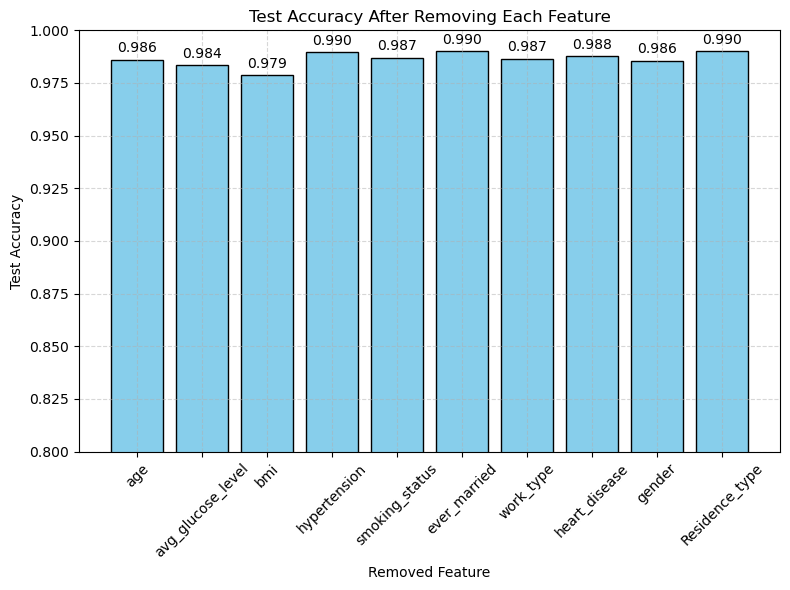

In [222]:
# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(features_removed, accuracies_after_removal, color='skyblue', edgecolor='black')

plt.xticks(rotation=45)
plt.ylabel('Test Accuracy')
plt.xlabel('Removed Feature')
plt.title('Test Accuracy After Removing Each Feature')
plt.ylim(0.80, 1.00)
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate each bar with its accuracy
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()
